# Import packages

In [44]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings('ignore')
import json 
import re
import string

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn import svm
from sklearn.svm import SVC

from scipy.spatial.distance import cdist
import shap
shap.initjs()
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
import scipy.spatial.distance as distance
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

# Load Data

In [45]:
# Read the csv file
df = pd.read_csv('hotel_bookings.csv')

In [46]:
# Create date
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


# Data Processing

## Data Leakage

In [47]:
# Data leakage columns removal
df = df.drop(columns=['country','assigned_room_type','days_in_waiting_list'])

## Missing Data Analysis

In [48]:
# Count the number of missing values for each feature
missing_values = df.isnull().sum()

# Calculate the percentage of missing data for each feature
percentage_missing = (missing_values / len(df)) * 100

# Create a DataFrame to store the results
missing_data_info = pd.DataFrame({'Number of Missing Values': missing_values, 'Percentage': percentage_missing})

# Sort the DataFrame by percentage missing in descending order
missing_data_info = missing_data_info.sort_values(by='Percentage', ascending=False)

missing_data_info

,Number of Missing Values,Percentage
company,112593,94.306893
agent,16340,13.686238
children,4,0.003350
hotel,0,0.000000
is_repeated_guest,0,0.000000
reservation_status,0,0.000000
total_of_special_requests,0,0.000000
required_car_parking_spaces,0,0.000000
adr,0,0.000000
customer_type,0,0.000000


In [49]:
# Missing data imputation
df['agent'] = df['agent'].fillna(0)
df['company'] = df['company'].fillna(0)

# Drop missing values of children
df = df.dropna()
df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,booking_changes,deposit_type,agent,company,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,3,No Deposit,0.0,0.0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,4,No Deposit,0.0,0.0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,0,No Deposit,0.0,0.0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,0,No Deposit,304.0,0.0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,0,No Deposit,240.0,0.0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,0,No Deposit,394.0,0.0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,0,No Deposit,9.0,0.0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,0,No Deposit,9.0,0.0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,0,No Deposit,89.0,0.0,Transient,104.40,0,0,Check-Out,2017-09-07


## Outlier Analysis

In [50]:
# Outlier analysis
index = ['adr', 'adults', 'babies', 'arrival_date_day_of_month', 'arrival_date_week_number', 
         'arrival_date_year', 'booking_changes', 'children', 
         'lead_time', 'previous_bookings_not_canceled', 'previous_cancellations', 
         'required_car_parking_spaces', 'stays_in_weekend_nights','stays_in_week_nights','total_of_special_requests']



for i, col in enumerate(index):
    
    # Calculate IQR and bounds
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Show outliers
    print(col, df.shape[0]-df[(df[col] >= lower_bound) & (df[col] <= upper_bound)].shape[0],round((df.shape[0]-df[(df[col] >= lower_bound) & (df[col] <= upper_bound)].shape[0])/df.shape[0]*100,2))

adr 3793 3.18
adults 29709 24.88
babies 917 0.77
arrival_date_day_of_month 0 0.0
arrival_date_week_number 0 0.0
arrival_date_year 0 0.0
booking_changes 18076 15.14
children 8590 7.2
lead_time 3005 2.52
previous_bookings_not_canceled 3620 3.03
previous_cancellations 6484 5.43
required_car_parking_spaces 7416 6.21
stays_in_weekend_nights 265 0.22
stays_in_week_nights 3354 2.81
total_of_special_requests 2877 2.41


In [51]:
outlier_data = []

for col in index:
    # Calculate IQR and bounds
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    
    # Count outliers
    outlier_count = df.shape[0] - df[(df[col] >= lower_bound) & (df[col] <= upper_bound)].shape[0]
    outlier_percent = round((outlier_count / df.shape[0]) * 100, 2)
    
    # Append data to list
    outlier_data.append([col, outlier_count, outlier_percent])
    
    

# Create dataframe
outlier_df = pd.merge(pd.DataFrame(outlier_data, columns=['Feature', 'Outlier Count', 'Outlier Percentage']),df[index].describe().T.rename_axis("Feature"),on ='Feature',how='left')

outlier_df.sort_values(by = 'Outlier Percentage', ascending = False)

,Feature,Outlier Count,Outlier Percentage,count,mean,std,min,25%,50%,75%,max
1,adults,29709,24.88,119386.0,1.856390,0.579261,0.00,2.00,2.00,2.0,55.0
6,booking_changes,18076,15.14,119386.0,0.221131,0.652315,0.00,0.00,0.00,0.0,21.0
7,children,8590,7.20,119386.0,0.103890,0.398561,0.00,0.00,0.00,0.0,10.0
11,required_car_parking_spaces,7416,6.21,119386.0,0.062520,0.245295,0.00,0.00,0.00,0.0,8.0
10,previous_cancellations,6484,5.43,119386.0,0.087121,0.844350,0.00,0.00,0.00,0.0,26.0
9,previous_bookings_not_canceled,3620,3.03,119386.0,0.137102,1.497462,0.00,0.00,0.00,0.0,72.0
13,stays_in_week_nights,1438,1.20,119386.0,2.500310,1.908289,0.00,1.00,2.00,3.0,50.0
2,babies,917,0.77,119386.0,0.007949,0.097438,0.00,0.00,0.00,0.0,10.0
0,adr,327,0.27,119386.0,101.833541,50.534664,-6.38,69.29,94.59,126.0,5400.0
8,lead_time,181,0.15,119386.0,104.014801,106.863286,0.00,18.00,69.00,160.0,737.0


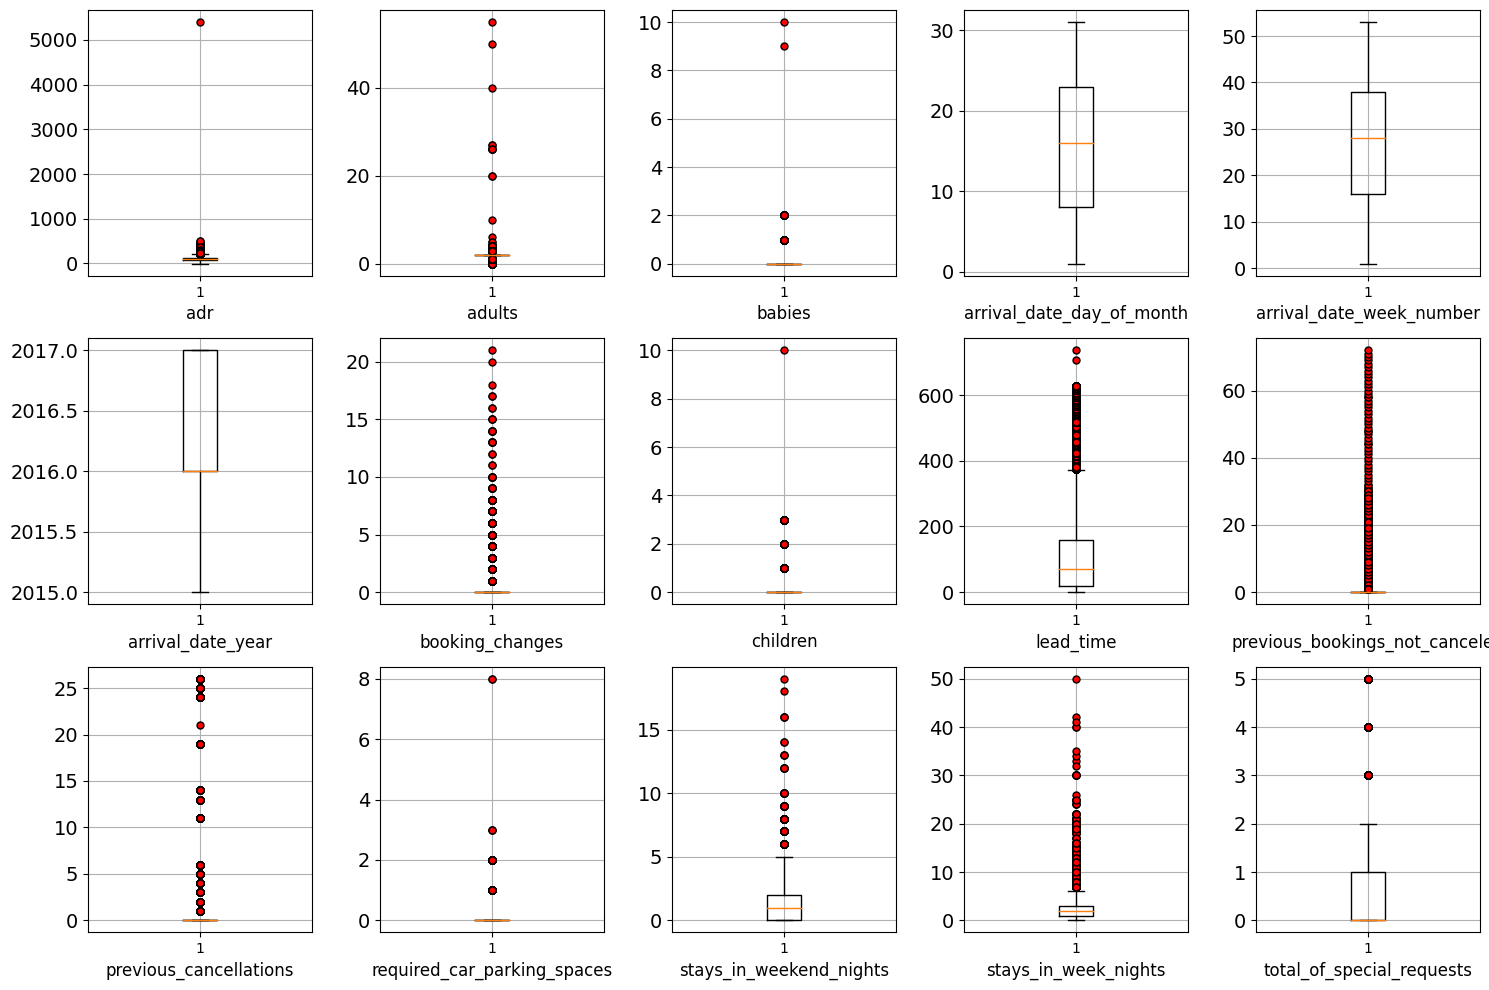

In [52]:
# Calculate number of rows required
num_cols = 5
num_rows = math.ceil(len(index) / num_cols)

# Create boxplots for each feature
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

for i, column in enumerate(index):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]
    ax.boxplot(df[column], vert=True, flierprops=dict(marker='o', markersize=5, linestyle='none', markerfacecolor='red'))
    ax.set_xlabel(column, fontsize=12)
    ax.tick_params(axis='y', labelsize=14)
    ax.grid(True)

# Hide empty subplots if any
if len(index) < num_rows * num_cols:
    for i in range(len(index), num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()


In [53]:
# Define a dictionary mapping month names to numerical values
month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}

# Convert month names to numerical values
df['arrival_date_month'] = df['arrival_date_month'].map(month_map)

# Create date
df['dateInt']=df['arrival_date_year'].astype(str) + df['arrival_date_month'].astype(str).str.zfill(2)+ df['arrival_date_day_of_month'].astype(str).str.zfill(2)
df['date'] = pd.to_datetime(df['dateInt'], format='%Y%m%d')
df = df.drop(columns=['dateInt'])

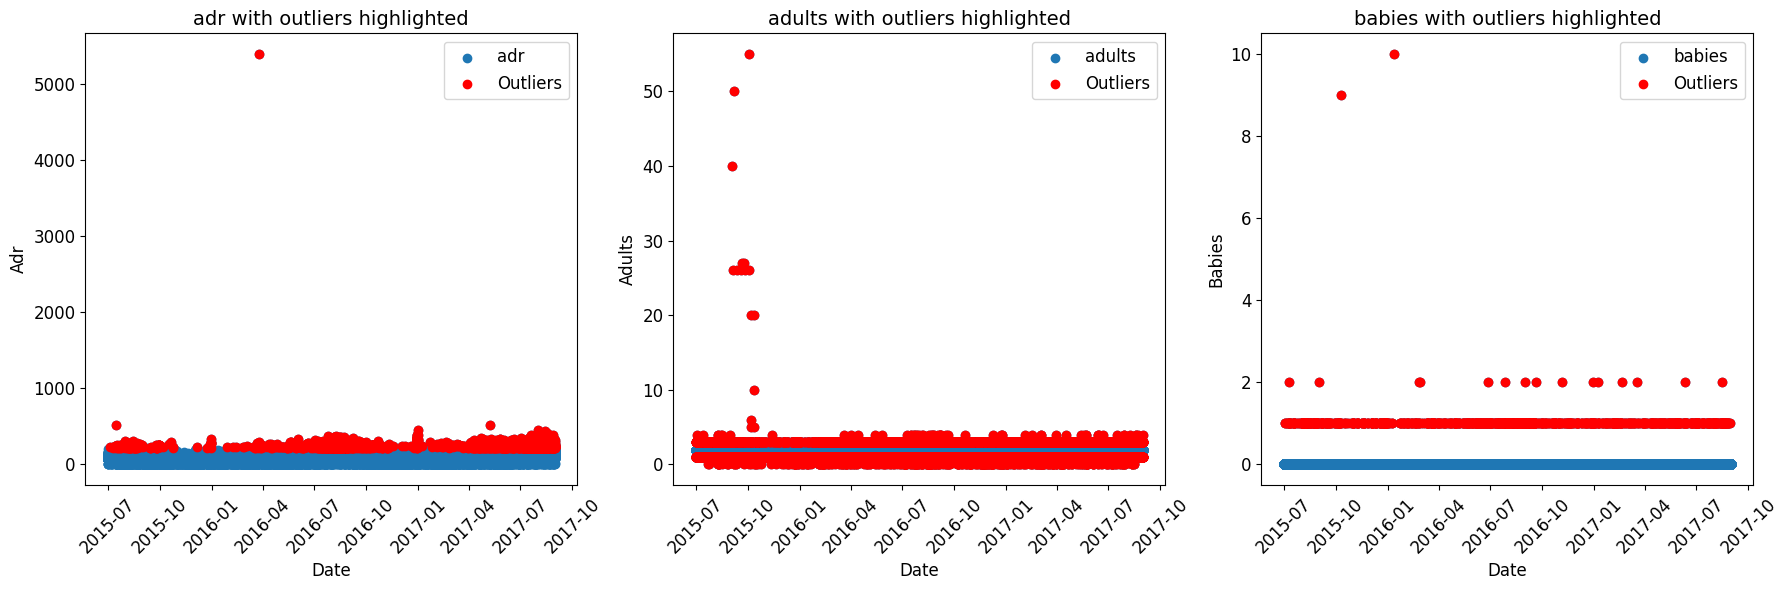

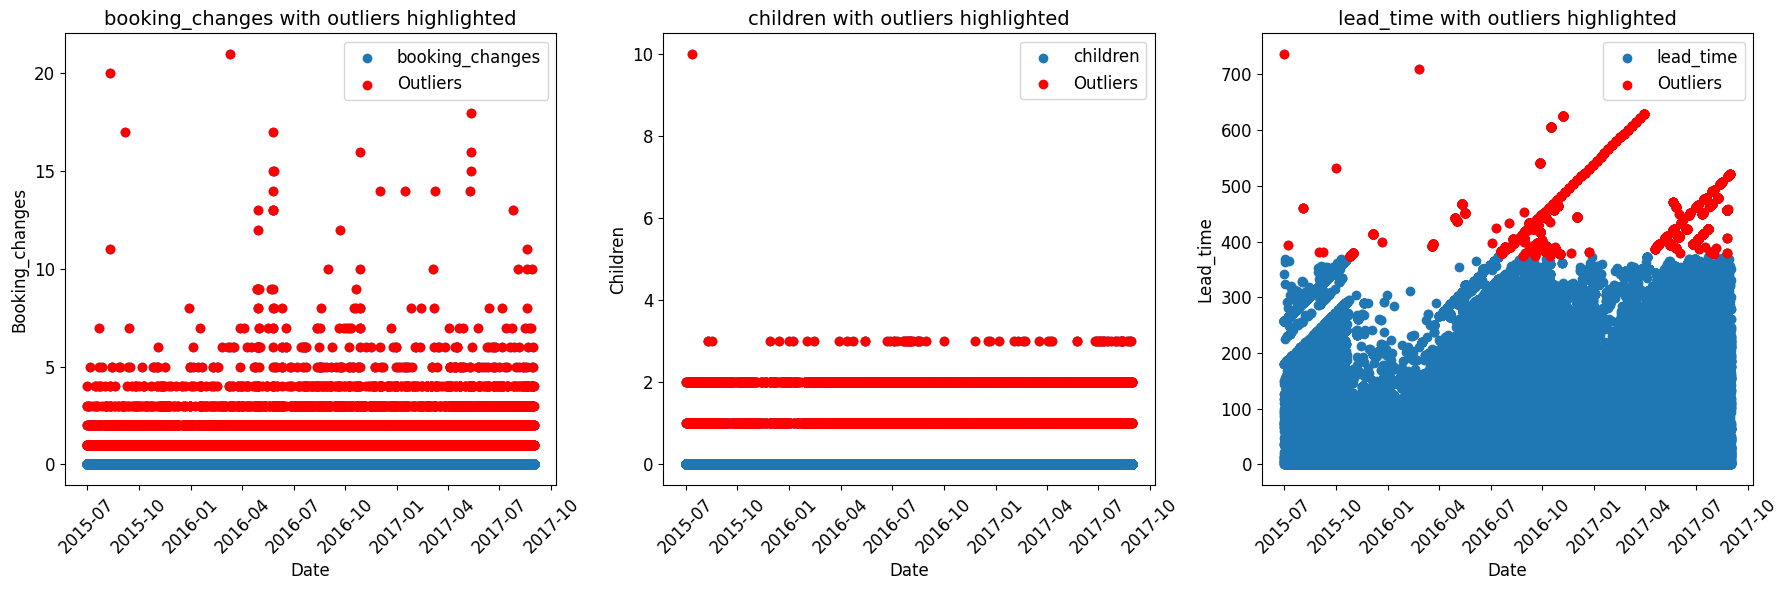

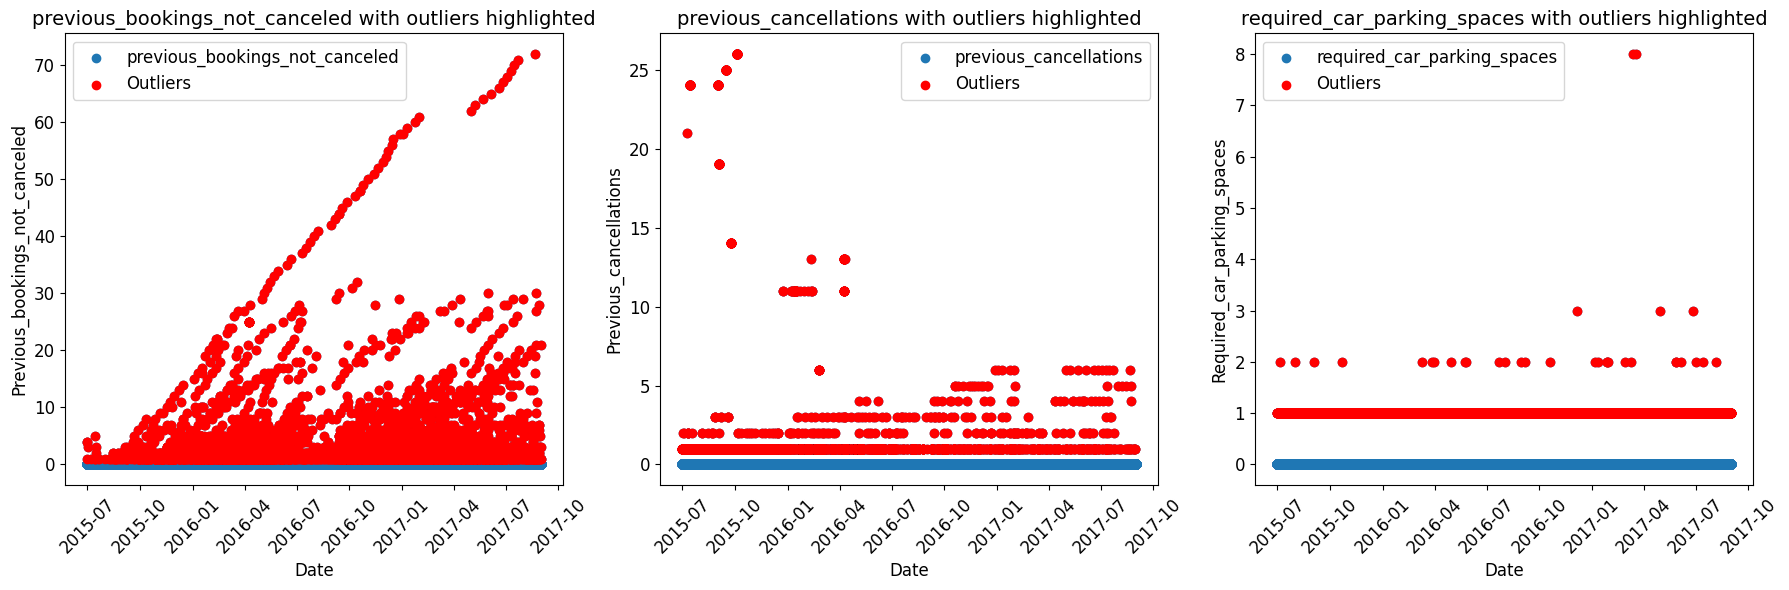

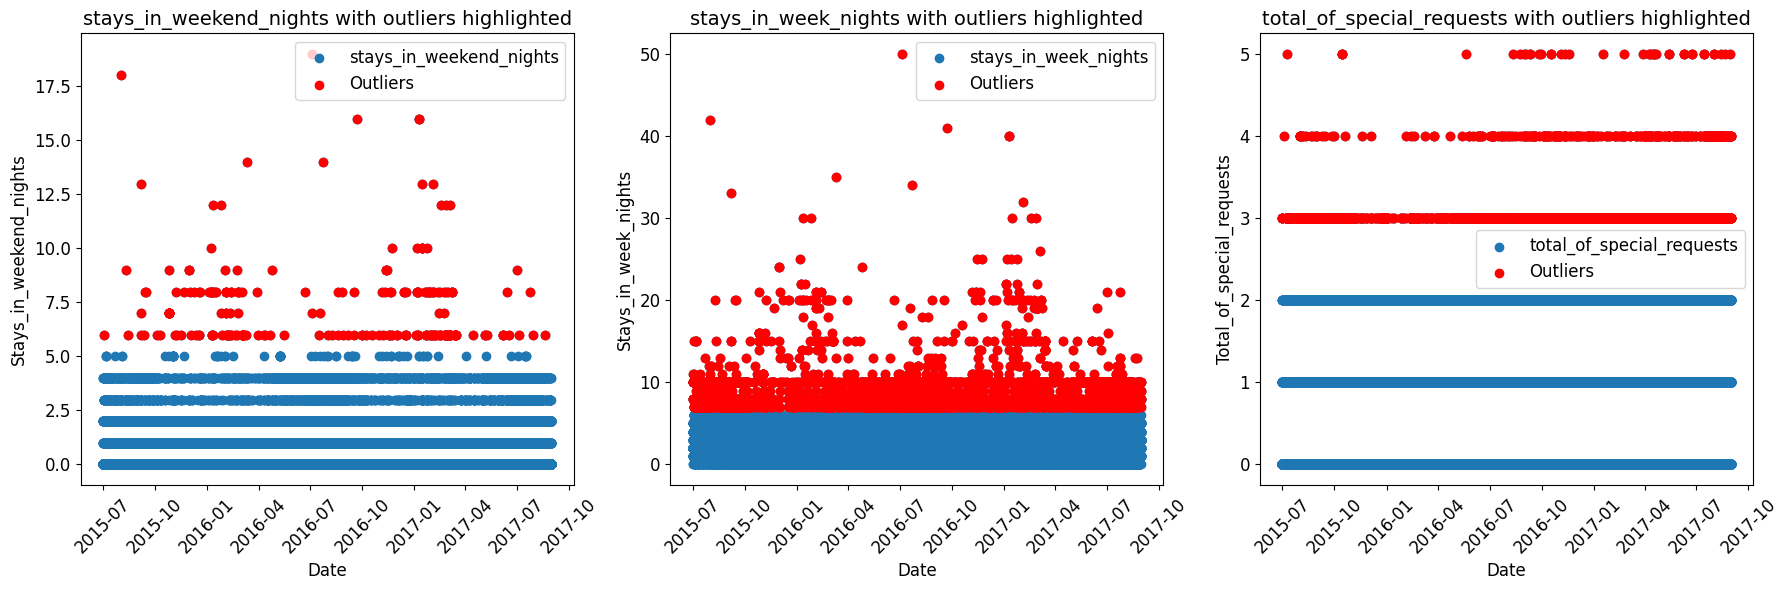

In [54]:
index = ['adr', 'adults', 'babies', 'booking_changes', 'children', 
         'lead_time', 'previous_bookings_not_canceled', 'previous_cancellations', 
         'required_car_parking_spaces', 'stays_in_weekend_nights','stays_in_week_nights','total_of_special_requests']

# Calculate number of rows needed
num_rows = int(np.ceil(len(index) / 3))

# Iterate through the indices and create plots
for i in range(num_rows):
    # Create a subplot with three columns
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot each index in the current row
    for j in range(3):
        idx = i * 3 + j
        if idx < len(index):
            col = index[idx]
            # Calculate outliers
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Identify outliers
            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

            # Plotting
            axes[j].scatter(df['date'], df[col], label=col)
            axes[j].scatter(outliers['date'], outliers[col], color='red', label='Outliers')

            # Formatting
            axes[j].set_title(f'{col} with outliers highlighted', fontsize=14)
            axes[j].set_xlabel('Date',fontsize=12)
            axes[j].set_ylabel(col.capitalize(),fontsize=12)
            axes[j].tick_params(axis='x', labelsize=12,rotation=45)  # Set x-axis tick label fontsize
            axes[j].tick_params(axis='y', labelsize=12)  # Set y-axis tick label fontsize
            axes[j].legend(fontsize=12)

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [55]:
# Remove outliers
df = df[df['adr'] <5000]

# Filtering Customers

In [56]:
# Find customers that fit the timeline
df = df[df['reservation_status_date'] >= df['date']]

# Data Splitting

In [57]:
## Split the data for training and testing
X = df.drop(columns=["is_canceled"])
y = df["is_canceled"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y,random_state=42)

In [58]:
# Reset index
X_train.reset_index(drop=True, inplace=True)
X_train

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,deposit_type,agent,company,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,date
0,City Hotel,6,2017,5,18,4,0,1,1,0.0,...,No Deposit,14.0,0.0,Transient-Party,175.00,0,1,Check-Out,2017-05-05,2017-05-04
1,Resort Hotel,48,2016,5,22,22,2,2,2,0.0,...,No Deposit,240.0,0.0,Transient,65.00,0,1,Check-Out,2016-05-26,2016-05-22
2,Resort Hotel,50,2016,11,46,9,1,4,2,0.0,...,No Deposit,6.0,0.0,Transient,52.40,0,0,Check-Out,2016-11-14,2016-11-09
3,Resort Hotel,5,2016,9,40,27,0,1,1,0.0,...,No Deposit,339.0,0.0,Transient,84.80,1,0,Check-Out,2016-09-28,2016-09-27
4,City Hotel,1,2016,7,28,8,2,2,3,0.0,...,No Deposit,9.0,0.0,Transient,184.50,0,2,Check-Out,2016-07-12,2016-07-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57934,City Hotel,71,2017,4,15,15,2,1,3,0.0,...,No Deposit,9.0,0.0,Transient,177.00,0,1,Check-Out,2017-04-18,2017-04-15
57935,City Hotel,75,2016,4,18,25,1,4,2,0.0,...,No Deposit,27.0,0.0,Transient,80.75,0,0,Check-Out,2016-04-30,2016-04-25
57936,City Hotel,7,2016,8,34,19,0,1,2,0.0,...,No Deposit,0.0,0.0,Transient,141.10,0,1,Check-Out,2016-08-20,2016-08-19
57937,Resort Hotel,1,2015,11,48,26,0,1,2,0.0,...,No Deposit,240.0,0.0,Transient,68.00,1,0,Check-Out,2015-11-27,2015-11-26


In [59]:
# Reset index
X_test.reset_index(drop=True, inplace=True)
X_test

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,deposit_type,agent,company,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,date
0,City Hotel,68,2017,5,20,14,2,1,1,0.0,...,No Deposit,0.0,169.0,Transient-Party,110.00,0,0,Check-Out,2017-05-17,2017-05-14
1,City Hotel,11,2015,10,43,23,0,1,1,0.0,...,No Deposit,26.0,0.0,Transient-Party,83.50,0,0,Check-Out,2015-10-24,2015-10-23
2,Resort Hotel,0,2016,11,45,5,0,1,2,0.0,...,No Deposit,0.0,0.0,Transient,84.00,1,0,Check-Out,2016-11-06,2016-11-05
3,Resort Hotel,80,2017,2,5,4,1,1,2,0.0,...,No Deposit,242.0,0.0,Transient-Party,63.65,0,1,Check-Out,2017-02-06,2017-02-04
4,Resort Hotel,27,2016,12,50,9,2,6,2,0.0,...,No Deposit,250.0,0.0,Transient,87.46,1,1,Check-Out,2016-12-17,2016-12-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19309,Resort Hotel,65,2017,3,10,9,0,2,2,0.0,...,No Deposit,0.0,0.0,Transient,40.00,0,1,Check-Out,2017-03-11,2017-03-09
19310,City Hotel,8,2017,2,9,27,1,2,2,0.0,...,No Deposit,9.0,0.0,Transient,117.00,0,0,Check-Out,2017-03-02,2017-02-27
19311,Resort Hotel,0,2017,1,2,14,0,1,2,0.0,...,No Deposit,0.0,0.0,Transient,44.00,0,1,Check-Out,2017-01-15,2017-01-14
19312,Resort Hotel,0,2015,12,50,10,0,1,1,0.0,...,No Deposit,0.0,144.0,Transient,25.00,0,0,Check-Out,2015-12-11,2015-12-10


# Feature Enginnering

In [60]:
# Training set
X_train['sum_of_weekend_nights_and_week_nights'] = X_train['stays_in_weekend_nights'] + X_train['stays_in_week_nights']  
X_train['interaction_nights_and_adr'] = X_train['sum_of_weekend_nights_and_week_nights'] * X_train['adr']  
X_train

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,company,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,date,sum_of_weekend_nights_and_week_nights,interaction_nights_and_adr
0,City Hotel,6,2017,5,18,4,0,1,1,0.0,...,0.0,Transient-Party,175.00,0,1,Check-Out,2017-05-05,2017-05-04,1,175.00
1,Resort Hotel,48,2016,5,22,22,2,2,2,0.0,...,0.0,Transient,65.00,0,1,Check-Out,2016-05-26,2016-05-22,4,260.00
2,Resort Hotel,50,2016,11,46,9,1,4,2,0.0,...,0.0,Transient,52.40,0,0,Check-Out,2016-11-14,2016-11-09,5,262.00
3,Resort Hotel,5,2016,9,40,27,0,1,1,0.0,...,0.0,Transient,84.80,1,0,Check-Out,2016-09-28,2016-09-27,1,84.80
4,City Hotel,1,2016,7,28,8,2,2,3,0.0,...,0.0,Transient,184.50,0,2,Check-Out,2016-07-12,2016-07-08,4,738.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57934,City Hotel,71,2017,4,15,15,2,1,3,0.0,...,0.0,Transient,177.00,0,1,Check-Out,2017-04-18,2017-04-15,3,531.00
57935,City Hotel,75,2016,4,18,25,1,4,2,0.0,...,0.0,Transient,80.75,0,0,Check-Out,2016-04-30,2016-04-25,5,403.75
57936,City Hotel,7,2016,8,34,19,0,1,2,0.0,...,0.0,Transient,141.10,0,1,Check-Out,2016-08-20,2016-08-19,1,141.10
57937,Resort Hotel,1,2015,11,48,26,0,1,2,0.0,...,0.0,Transient,68.00,1,0,Check-Out,2015-11-27,2015-11-26,1,68.00


In [61]:
# Testing set
X_test['sum_of_weekend_nights_and_week_nights'] = X_test['stays_in_weekend_nights'] + X_test['stays_in_week_nights']  
X_test['interaction_nights_and_adr'] = X_test['sum_of_weekend_nights_and_week_nights'] * X_test['adr']  
X_test

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,company,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,date,sum_of_weekend_nights_and_week_nights,interaction_nights_and_adr
0,City Hotel,68,2017,5,20,14,2,1,1,0.0,...,169.0,Transient-Party,110.00,0,0,Check-Out,2017-05-17,2017-05-14,3,330.00
1,City Hotel,11,2015,10,43,23,0,1,1,0.0,...,0.0,Transient-Party,83.50,0,0,Check-Out,2015-10-24,2015-10-23,1,83.50
2,Resort Hotel,0,2016,11,45,5,0,1,2,0.0,...,0.0,Transient,84.00,1,0,Check-Out,2016-11-06,2016-11-05,1,84.00
3,Resort Hotel,80,2017,2,5,4,1,1,2,0.0,...,0.0,Transient-Party,63.65,0,1,Check-Out,2017-02-06,2017-02-04,2,127.30
4,Resort Hotel,27,2016,12,50,9,2,6,2,0.0,...,0.0,Transient,87.46,1,1,Check-Out,2016-12-17,2016-12-09,8,699.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19309,Resort Hotel,65,2017,3,10,9,0,2,2,0.0,...,0.0,Transient,40.00,0,1,Check-Out,2017-03-11,2017-03-09,2,80.00
19310,City Hotel,8,2017,2,9,27,1,2,2,0.0,...,0.0,Transient,117.00,0,0,Check-Out,2017-03-02,2017-02-27,3,351.00
19311,Resort Hotel,0,2017,1,2,14,0,1,2,0.0,...,0.0,Transient,44.00,0,1,Check-Out,2017-01-15,2017-01-14,1,44.00
19312,Resort Hotel,0,2015,12,50,10,0,1,1,0.0,...,144.0,Transient,25.00,0,0,Check-Out,2015-12-11,2015-12-10,1,25.00


# Feature Encoding and Scaling

In [62]:
# Standardization and one-hot encoding
featurizer = ColumnTransformer(
        transformers=[
            ("hotel", OneHotEncoder(handle_unknown='ignore', sparse=False), ["hotel"]),
            ("lead_time", StandardScaler(), ["lead_time"]),
            ("arrival_date_year", OneHotEncoder(handle_unknown='ignore', sparse=False), ["arrival_date_year"]),
            ("arrival_date_month", OneHotEncoder(handle_unknown='ignore', sparse=False), ["arrival_date_month"]),
            ("arrival_date_day_of_month", OneHotEncoder(handle_unknown='ignore', sparse=False), ["arrival_date_day_of_month"]),
            ("arrival_date_week_number", OneHotEncoder(handle_unknown='ignore', sparse=False), ["arrival_date_week_number"]),
            ("stays_in_weekend_nights",  StandardScaler(), ["stays_in_weekend_nights"]),
            ("stays_in_week_nights",  StandardScaler(), ["stays_in_week_nights"]),
            ("adults", StandardScaler(), ["adults"]),
            ("children", StandardScaler(), ["children"]),
            ("babies", StandardScaler(), ["babies"]),
            ("meal", OneHotEncoder(handle_unknown='ignore', sparse=False), ["meal"]),
            ("market_segment", OneHotEncoder(handle_unknown='ignore', sparse=False), ["market_segment"]),
            ("distribution_channel", OneHotEncoder(handle_unknown='ignore', sparse=False), ["distribution_channel"]),
            ("is_repeated_guest", OneHotEncoder(handle_unknown='ignore', sparse=False), ["is_repeated_guest"]),
            ("previous_cancellations", StandardScaler(), ["previous_cancellations"]),
            ("previous_bookings_not_canceled", StandardScaler(), ["previous_bookings_not_canceled"]),
            ("reserved_room_type", OneHotEncoder(handle_unknown='ignore', sparse=False), ["reserved_room_type"]),
            ("booking_changes", StandardScaler(), ["booking_changes"]),
            ("deposit_type", OneHotEncoder(handle_unknown='ignore', sparse=False), ["deposit_type"]),
            ("agent", OneHotEncoder(handle_unknown='ignore', sparse=False), ["agent"]),
            ("company", OneHotEncoder(handle_unknown='ignore', sparse=False), ["company"]),
            ("customer_type", OneHotEncoder(handle_unknown='ignore', sparse=False), ["customer_type"]),
            ("adr", StandardScaler(), ["adr"]),
            ("required_car_parking_spaces", StandardScaler(), ["required_car_parking_spaces"]),
            ("total_of_special_requests", StandardScaler(), ["total_of_special_requests"]),
            ("sum_of_weekend_nights_and_week_nights", StandardScaler(), ["sum_of_weekend_nights_and_week_nights"]),
            ("interaction_nights_and_adr", StandardScaler(), ["interaction_nights_and_adr"])
        ],
    remainder='drop')

# Train
transformed_train = featurizer.fit_transform(X_train)
df_train = pd.DataFrame(transformed_train, columns=featurizer.get_feature_names_out())

# Test
transformed_test = featurizer.transform(X_test)
df_test = pd.DataFrame(transformed_test, columns=featurizer.get_feature_names_out())

In [63]:
# Train
df_train.shape

(57939, 772)

In [64]:
# Test
df_test.shape

(19314, 772)

In [65]:
def rename_columns(df):
    renamed_columns = []
    for col in df.columns:
        if '__' in col:
            # Split the column name by '__' and take the second part
            new_col_name = col.split('__')[1]
            renamed_columns.append(new_col_name)
        else:
            renamed_columns.append(col)
    return renamed_columns

# Rename columns in training data
df_train.columns = rename_columns(df_train)

# Rename columns in testing data
df_test.columns = rename_columns(df_test)

# Feature Selection

In [66]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Fit the classifier to your training data
rf_classifier.fit(df_train, y_train)

# Use feature importance from the trained model for feature selection
feature_importances = rf_classifier.feature_importances_

# Use SelectFromModel to select features based on their importance
selector = SelectFromModel(rf_classifier, prefit=True)

# Transform the training and testing datasets to select the important features
X_train_selected = selector.transform(df_train)
X_test_selected = selector.transform(df_test)

# Get boolean mask indicating selected features
selected_features_mask = selector.get_support()

# Get names of all features
all_feature_names = df_train.columns

# Get names of selected features
selected_feature_names = all_feature_names[selected_features_mask]

# Create DataFrame with only selected features for training set
X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_feature_names)

# Create DataFrame with only selected features for testing set
X_test_selected_df = pd.DataFrame(X_test_selected, columns=selected_feature_names)

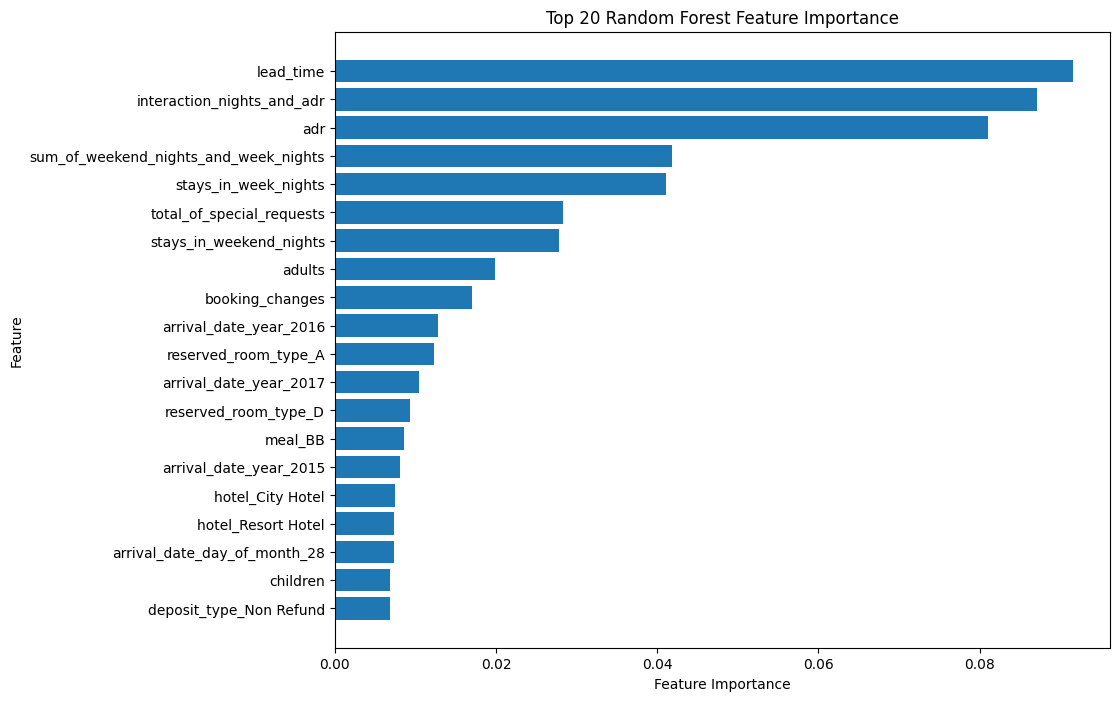

In [67]:
# Get feature names
feature_names = df_train.columns

# Sort feature importances in descending order
sorted_indices = feature_importances.argsort()[::-1]
top_twenty_indices = sorted_indices[:20]
top_twenty_features = [feature_names[i] for i in top_twenty_indices]
top_twenty_importances = feature_importances[top_twenty_indices]

# Plot top twenty feature importances in descending order
plt.figure(figsize=(10, 8))
plt.barh(range(len(top_twenty_importances)), top_twenty_importances, align='center')
plt.yticks(range(len(top_twenty_importances)), top_twenty_features)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Random Forest Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to display top to bottom
plt.show()


In [68]:
X_train_selected_df

,hotel_City Hotel,hotel_Resort Hotel,lead_time,arrival_date_year_2015,arrival_date_year_2016,arrival_date_year_2017,arrival_date_month_1,arrival_date_month_2,arrival_date_month_3,arrival_date_month_4,...,company_135.0,company_279.0,customer_type_Contract,customer_type_Transient,customer_type_Transient-Party,adr,required_car_parking_spaces,total_of_special_requests,sum_of_weekend_nights_and_week_nights,interaction_nights_and_adr
0,1.0,0.0,-0.804481,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.534988,-0.32110,0.349057,-0.913531,-0.521541
1,0.0,1.0,-0.340386,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,-0.709580,-0.32110,0.349057,0.235768,-0.259978
2,0.0,1.0,-0.318286,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,-0.966685,-0.32110,-0.849971,0.618868,-0.253824
3,0.0,1.0,-0.815531,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,-0.305558,3.04253,-0.849971,-0.913531,-0.799104
4,1.0,0.0,-0.859731,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.728837,-0.32110,1.548084,0.235768,1.210925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57934,1.0,0.0,-0.086238,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.575799,-0.32110,0.349057,-0.147331,0.573944
57935,1.0,0.0,-0.042039,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,-0.388199,-0.32110,-0.849971,0.618868,0.182369
57936,1.0,0.0,-0.793431,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.843253,-0.32110,0.349057,-0.913531,-0.625858
57937,0.0,1.0,-0.859731,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,-0.648364,3.04253,-0.849971,-0.913531,-0.850801


In [69]:
X_train_selected_df['hotel'] = X_train['hotel']
X_train_selected_df['date'] = X_train['date']
X_train_selected_df

,hotel_City Hotel,hotel_Resort Hotel,lead_time,arrival_date_year_2015,arrival_date_year_2016,arrival_date_year_2017,arrival_date_month_1,arrival_date_month_2,arrival_date_month_3,arrival_date_month_4,...,customer_type_Contract,customer_type_Transient,customer_type_Transient-Party,adr,required_car_parking_spaces,total_of_special_requests,sum_of_weekend_nights_and_week_nights,interaction_nights_and_adr,hotel,date
0,1.0,0.0,-0.804481,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.534988,-0.32110,0.349057,-0.913531,-0.521541,City Hotel,2017-05-04
1,0.0,1.0,-0.340386,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-0.709580,-0.32110,0.349057,0.235768,-0.259978,Resort Hotel,2016-05-22
2,0.0,1.0,-0.318286,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-0.966685,-0.32110,-0.849971,0.618868,-0.253824,Resort Hotel,2016-11-09
3,0.0,1.0,-0.815531,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-0.305558,3.04253,-0.849971,-0.913531,-0.799104,Resort Hotel,2016-09-27
4,1.0,0.0,-0.859731,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.728837,-0.32110,1.548084,0.235768,1.210925,City Hotel,2016-07-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57934,1.0,0.0,-0.086238,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.575799,-0.32110,0.349057,-0.147331,0.573944,City Hotel,2017-04-15
57935,1.0,0.0,-0.042039,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,-0.388199,-0.32110,-0.849971,0.618868,0.182369,City Hotel,2016-04-25
57936,1.0,0.0,-0.793431,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.843253,-0.32110,0.349057,-0.913531,-0.625858,City Hotel,2016-08-19
57937,0.0,1.0,-0.859731,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-0.648364,3.04253,-0.849971,-0.913531,-0.850801,Resort Hotel,2015-11-26


In [70]:
X_test_selected_df['hotel'] = X_test['hotel']
X_test_selected_df['date'] = X_test['date']
X_test_selected_df

,hotel_City Hotel,hotel_Resort Hotel,lead_time,arrival_date_year_2015,arrival_date_year_2016,arrival_date_year_2017,arrival_date_month_1,arrival_date_month_2,arrival_date_month_3,arrival_date_month_4,...,customer_type_Contract,customer_type_Transient,customer_type_Transient-Party,adr,required_car_parking_spaces,total_of_special_requests,sum_of_weekend_nights_and_week_nights,interaction_nights_and_adr,hotel,date
0,1.0,0.0,-0.119388,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.208652,-0.32110,-0.849971,-0.147331,-0.044574,City Hotel,2017-05-14
1,1.0,0.0,-0.749232,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-0.332084,-0.32110,-0.849971,-0.913531,-0.803105,City Hotel,2015-10-23
2,0.0,1.0,-0.870781,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-0.321882,3.04253,-0.849971,-0.913531,-0.801566,Resort Hotel,2016-11-05
3,0.0,1.0,0.013211,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,-0.737127,-0.32110,0.349057,-0.530431,-0.668323,Resort Hotel,2017-02-04
4,0.0,1.0,-0.572433,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-0.251280,3.04253,0.349057,1.768167,1.093006,Resort Hotel,2016-12-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19309,0.0,1.0,-0.152538,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,-1.219709,-0.32110,0.349057,-0.530431,-0.813875,Resort Hotel,2017-03-09
19310,1.0,0.0,-0.782381,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.351489,-0.32110,-0.849971,-0.147331,0.020047,City Hotel,2017-02-27
19311,0.0,1.0,-0.870781,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-1.138088,-0.32110,0.349057,-0.913531,-0.924654,Resort Hotel,2017-01-14
19312,0.0,1.0,-0.870781,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-1.525786,-0.32110,-0.849971,-0.913531,-0.983121,Resort Hotel,2015-12-10


# Load Weather Data

In [71]:
# Import data
df_wea = pd.read_csv('weather_data_2015_2017.csv')
df_wea = df_wea[['mintempC','maxtempC','avgtempC','date','Hotel']]
df_wea.rename(columns={'Hotel': 'hotel'}, inplace=True)
df_wea['date'] = pd.to_datetime(df_wea['date'])
df_wea

,mintempC,maxtempC,avgtempC,date,hotel
0,17,23,20,2015-07-01,City Hotel
1,16,24,20,2015-07-02,City Hotel
2,15,25,20,2015-07-03,City Hotel
3,17,27,22,2015-07-04,City Hotel
4,17,26,21,2015-07-05,City Hotel
...,...,...,...,...,...
1581,20,26,23,2017-08-27,Resort Hotel
1582,19,23,21,2017-08-28,Resort Hotel
1583,19,24,21,2017-08-29,Resort Hotel
1584,20,26,23,2017-08-30,Resort Hotel


In [72]:
# Combine data
X_train_selected_df = pd.merge(X_train_selected_df,df_wea,on=['date','hotel'],how='left')
X_train_selected_df

,hotel_City Hotel,hotel_Resort Hotel,lead_time,arrival_date_year_2015,arrival_date_year_2016,arrival_date_year_2017,arrival_date_month_1,arrival_date_month_2,arrival_date_month_3,arrival_date_month_4,...,adr,required_car_parking_spaces,total_of_special_requests,sum_of_weekend_nights_and_week_nights,interaction_nights_and_adr,hotel,date,mintempC,maxtempC,avgtempC
0,1.0,0.0,-0.804481,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.534988,-0.32110,0.349057,-0.913531,-0.521541,City Hotel,2017-05-04,16,22,18
1,0.0,1.0,-0.340386,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.709580,-0.32110,0.349057,0.235768,-0.259978,Resort Hotel,2016-05-22,16,22,19
2,0.0,1.0,-0.318286,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.966685,-0.32110,-0.849971,0.618868,-0.253824,Resort Hotel,2016-11-09,14,19,17
3,0.0,1.0,-0.815531,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.305558,3.04253,-0.849971,-0.913531,-0.799104,Resort Hotel,2016-09-27,21,28,24
4,1.0,0.0,-0.859731,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.728837,-0.32110,1.548084,0.235768,1.210925,City Hotel,2016-07-08,18,29,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57934,1.0,0.0,-0.086238,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.575799,-0.32110,0.349057,-0.147331,0.573944,City Hotel,2017-04-15,12,21,16
57935,1.0,0.0,-0.042039,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,-0.388199,-0.32110,-0.849971,0.618868,0.182369,City Hotel,2016-04-25,12,23,17
57936,1.0,0.0,-0.793431,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.843253,-0.32110,0.349057,-0.913531,-0.625858,City Hotel,2016-08-19,18,26,21
57937,0.0,1.0,-0.859731,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.648364,3.04253,-0.849971,-0.913531,-0.850801,Resort Hotel,2015-11-26,12,20,15


In [73]:
X_test_selected_df = pd.merge(X_test_selected_df,df_wea,on=['date','hotel'],how='left')
X_test_selected_df

,hotel_City Hotel,hotel_Resort Hotel,lead_time,arrival_date_year_2015,arrival_date_year_2016,arrival_date_year_2017,arrival_date_month_1,arrival_date_month_2,arrival_date_month_3,arrival_date_month_4,...,adr,required_car_parking_spaces,total_of_special_requests,sum_of_weekend_nights_and_week_nights,interaction_nights_and_adr,hotel,date,mintempC,maxtempC,avgtempC
0,1.0,0.0,-0.119388,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.208652,-0.32110,-0.849971,-0.147331,-0.044574,City Hotel,2017-05-14,15,21,18
1,1.0,0.0,-0.749232,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.332084,-0.32110,-0.849971,-0.913531,-0.803105,City Hotel,2015-10-23,16,21,19
2,0.0,1.0,-0.870781,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.321882,3.04253,-0.849971,-0.913531,-0.801566,Resort Hotel,2016-11-05,16,20,18
3,0.0,1.0,0.013211,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,-0.737127,-0.32110,0.349057,-0.530431,-0.668323,Resort Hotel,2017-02-04,14,16,15
4,0.0,1.0,-0.572433,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.251280,3.04253,0.349057,1.768167,1.093006,Resort Hotel,2016-12-09,16,18,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19309,0.0,1.0,-0.152538,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,-1.219709,-0.32110,0.349057,-0.530431,-0.813875,Resort Hotel,2017-03-09,15,20,17
19310,1.0,0.0,-0.782381,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.351489,-0.32110,-0.849971,-0.147331,0.020047,City Hotel,2017-02-27,11,16,13
19311,0.0,1.0,-0.870781,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,-1.138088,-0.32110,0.349057,-0.913531,-0.924654,Resort Hotel,2017-01-14,8,14,10
19312,0.0,1.0,-0.870781,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.525786,-0.32110,-0.849971,-0.913531,-0.983121,Resort Hotel,2015-12-10,16,18,17


# Perform Standardization and Remove Unnecessary Features

In [33]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_feature_scaled = scaler.fit_transform(X_train_selected_df[['avgtempC']])

# Transform the testing data using the same scaler
X_test_feature_scaled = scaler.transform(X_test_selected_df[['avgtempC']])

# Replace the standardized feature in the original datasets
X_train_selected_df['avgtempC'] = X_train_feature_scaled
X_test_selected_df['avgtempC'] = X_test_feature_scaled

In [34]:
# Remove unecessary features
X_train_selected_df.drop(columns=['hotel', 'date','mintempC','maxtempC'],inplace=True)
X_test_selected_df.drop(columns=['hotel', 'date','mintempC','maxtempC'],inplace=True)

# Data Imblance

## Without SMOTE

In [35]:
# X_train_selected_df

In [36]:
# X_test_selected_df

## With SMOTE

In [37]:
# SMOTE
smote = SMOTE(random_state=42)

In [38]:
# Resampling
X_resampled, y_resampled = smote.fit_resample(X_train_selected_df, y_train)

In [39]:
X_resampled

,hotel_City Hotel,hotel_Resort Hotel,lead_time,arrival_date_year_2015,arrival_date_year_2016,arrival_date_year_2017,arrival_date_month_1,arrival_date_month_2,arrival_date_month_3,arrival_date_month_4,...,company_279.0,customer_type_Contract,customer_type_Transient,customer_type_Transient-Party,adr,required_car_parking_spaces,total_of_special_requests,sum_of_weekend_nights_and_week_nights,interaction_nights_and_adr,avgtempC
0,1.000000,0.000000,-0.804481,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,1.0,1.534988,-0.32110,0.349057,-0.913531,-0.521541,-0.024344
1,0.000000,1.000000,-0.340386,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,1.000000,0.0,-0.709580,-0.32110,0.349057,0.235768,-0.259978,0.210146
2,0.000000,1.000000,-0.318286,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,1.000000,0.0,-0.966685,-0.32110,-0.849971,0.618868,-0.253824,-0.258834
3,0.000000,1.000000,-0.815531,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,1.000000,0.0,-0.305558,3.04253,-0.849971,-0.913531,-0.799104,1.382595
4,1.000000,0.000000,-0.859731,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,1.000000,0.0,1.728837,-0.32110,1.548084,0.235768,1.210925,1.148105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112743,1.000000,0.000000,-0.867088,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,1.000000,0.0,-0.066922,-0.32110,0.749689,-0.913531,-0.763117,-0.024344
112744,1.000000,0.000000,-0.837631,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,1.000000,0.0,-0.021562,-0.32110,-0.849971,0.707587,0.455202,0.210146
112745,1.000000,0.000000,1.394448,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,1.000000,0.0,-0.291274,-0.32110,1.548084,0.235768,-0.007648,0.444636
112746,0.045659,0.954341,0.656329,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.045659,0.954341,0.0,-0.460281,-0.32110,-0.795224,2.534367,1.316087,0.881496


# Modeling & Hyperparamter Tuning

## Without SMOTE

### Without Temp

#### Dummy

Dummy
Best Parameters: {'strategy': 'uniform'}
              precision    recall  f1-score   support

           0       0.97      0.50      0.66     18792
           1       0.03      0.51      0.05       522

    accuracy                           0.50     19314
   macro avg       0.50      0.51      0.36     19314
weighted avg       0.95      0.50      0.65     19314

AUC: 0.5


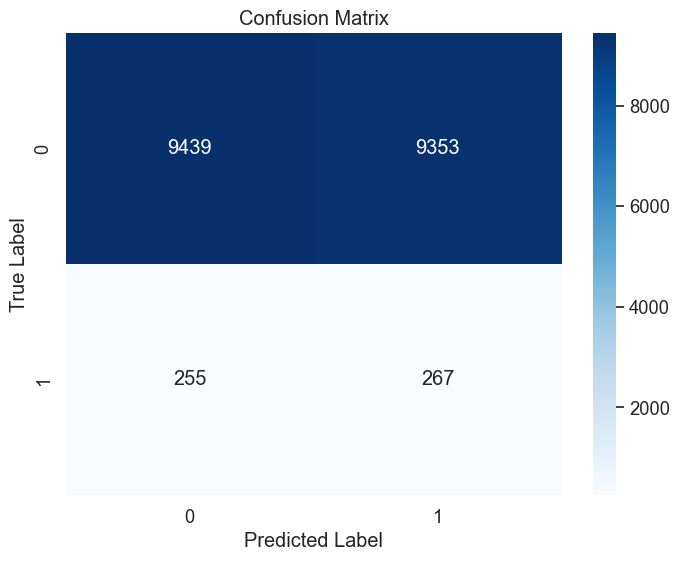

In [40]:
# Define the parameter grid to search
param_grid = {
    'strategy': ['stratified', 'most_frequent', 'uniform', 'constant','prior']
}

dc = DummyClassifier(random_state=42)

# Initialize GridSearchCV
grid_search_dc = GridSearchCV(dc, param_grid, cv=5, scoring='f1')

# Perform the grid search
grid_search_dc.fit(X_train_selected_df.drop(columns=['avgtempC']), y_train)

# Get the best model
best_dummy_clf = grid_search_dc.best_estimator_

# Make predictions
y_pred = best_dummy_clf.predict(X_test_selected_df.drop(columns=['avgtempC']))

# Calculate probability For AUC
y_proba = best_dummy_clf.predict_proba(X_test_selected_df.drop(columns=['avgtempC']))

# Evaluate the classifier
report = classification_report(y_test, y_pred)
print('Dummy')
print("Best Parameters:", grid_search_dc.best_params_)
print(report)
print('AUC:',roc_auc_score(y_test, y_proba[:, 1]))
cm = confusion_matrix(y_test, y_pred, labels=best_dummy_clf.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2) 
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=best_dummy_clf.classes_, yticklabels=best_dummy_clf.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### RF

RF
Best Parameters: {'max_depth': None, 'max_features': 0.5, 'min_samples_split': 2, 'n_estimators': 500}
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     18792
           1       0.71      0.18      0.29       522

    accuracy                           0.98     19314
   macro avg       0.85      0.59      0.64     19314
weighted avg       0.97      0.98      0.97     19314

AUC: 0.7899726324399884


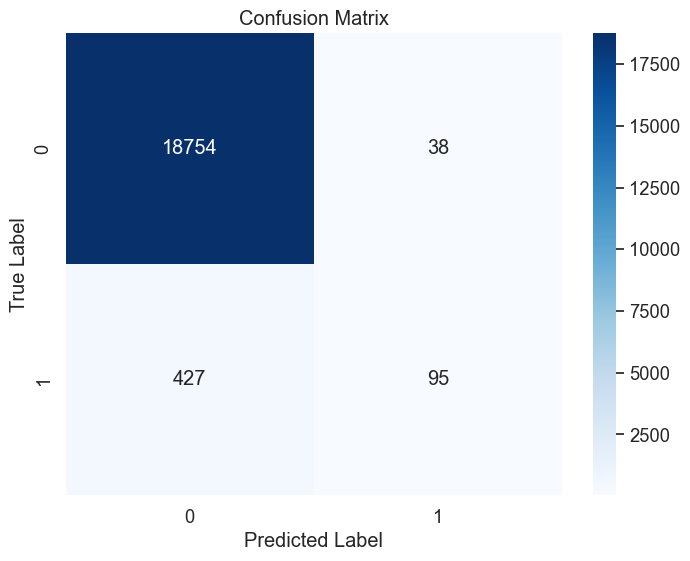

In [41]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2', 0.5, None]
}

rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(rf, param_grid, cv=5, scoring='f1', n_jobs = -1)

# Perform the grid search
grid_search_rf.fit(X_train_selected_df.drop(columns=['avgtempC']), y_train)

# Get the best model
best_rf = grid_search_rf.best_estimator_

# Make predictions
y_pred = best_rf.predict(X_test_selected_df.drop(columns=['avgtempC']))

# Calculate probability For AUC
y_proba = best_rf.predict_proba(X_test_selected_df.drop(columns=['avgtempC']))

# Evaluate the classifier
report = classification_report(y_test, y_pred)
print('RF')
print("Best Parameters:", grid_search_rf.best_params_)
print(report)
print('AUC:',roc_auc_score(y_test, y_proba[:, 1]))
cm = confusion_matrix(y_test, y_pred, labels=best_rf.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2) 
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=best_rf.classes_, yticklabels=best_rf.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### SVME - Linear

SVM - Linear
Best Parameters: {'estimator__C': 0.1}
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18792
           1       0.00      0.00      0.00       522

    accuracy                           0.97     19314
   macro avg       0.49      0.50      0.49     19314
weighted avg       0.95      0.97      0.96     19314

AUC: 0.6447676744322602


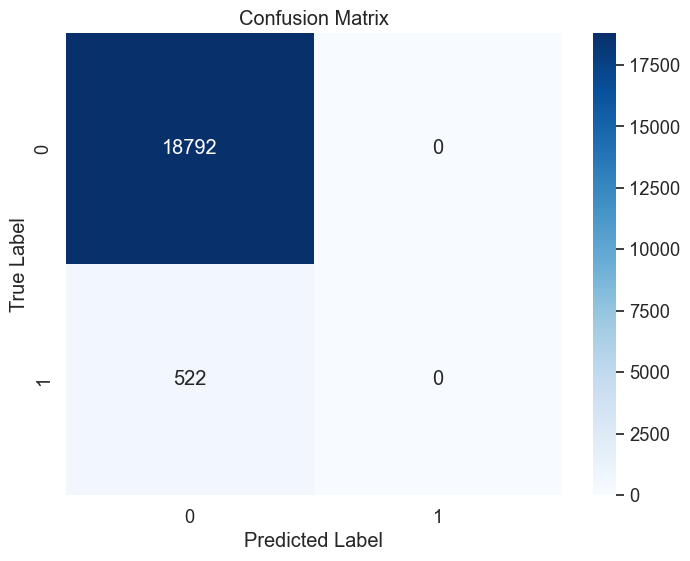

In [83]:
# Define the parameter grid to search
param_grid = {
    'estimator__C': [0.1, 1, 10]
}


svm_linear = BaggingClassifier(SVC(kernel='linear', probability=True,random_state=42), max_samples=1.0 / 10, n_estimators=10,random_state=42,n_jobs = -1)

# Initialize GridSearchCV
grid_search_svm_linear = GridSearchCV(svm_linear, param_grid, cv=5, scoring='f1',n_jobs = -1)

# Perform the grid search
grid_search_svm_linear.fit(X_train_selected_df.drop(columns=['avgtempC']), y_train)

# Get the best model
best_svm_linear = grid_search_svm_linear.best_estimator_

# Make predictions
y_pred = best_svm_linear.predict(X_test_selected_df.drop(columns=['avgtempC']))

# Calculate probability For AUC
y_proba = best_svm_linear.predict_proba(X_test_selected_df.drop(columns=['avgtempC']))

# Evaluate the classifier
report = classification_report(y_test, y_pred)
print('SVM - Linear')
print("Best Parameters:", grid_search_svm_linear.best_params_)
print(report)
print('AUC:',roc_auc_score(y_test, y_proba[:, 1]))
cm = confusion_matrix(y_test, y_pred, labels=best_svm_linear.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=best_svm_linear.classes_, yticklabels=best_svm_linear.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### SVME - Sigmoid

SVM - sigmoid
Best Parameters: {'estimator__C': 0.1}
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18792
           1       0.00      0.00      0.00       522

    accuracy                           0.97     19314
   macro avg       0.49      0.50      0.49     19314
weighted avg       0.95      0.97      0.96     19314

AUC: 0.6245111333754153


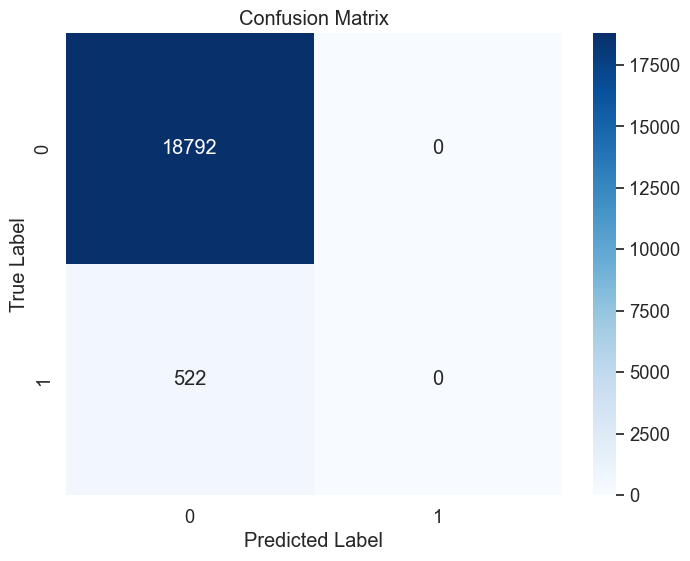

In [84]:
# Define the parameter grid to search
param_grid = {
    'estimator__C': [0.1, 1, 10]
}


svm_sigmoid = BaggingClassifier(SVC(kernel='sigmoid', probability=True,random_state=42), max_samples=1.0 / 10, n_estimators=10,random_state=42,n_jobs = -1)

# Initialize GridSearchCV
grid_search_svm_sigmoid = GridSearchCV(svm_sigmoid, param_grid, cv=5, scoring='f1',n_jobs = -1)

# Perform the grid search
grid_search_svm_sigmoid.fit(X_train_selected_df.drop(columns=['avgtempC']), y_train)

# Get the best model
best_svm_sigmoid = grid_search_svm_sigmoid.best_estimator_

# Make predictions
y_pred = best_svm_sigmoid.predict(X_test_selected_df.drop(columns=['avgtempC']))

# Calculate probability For AUC
y_proba = best_svm_sigmoid.predict_proba(X_test_selected_df.drop(columns=['avgtempC']))

# Evaluate the classifier
report = classification_report(y_test, y_pred)
print('SVM - sigmoid')
print("Best Parameters:", grid_search_svm_sigmoid.best_params_)
print(report)
print('AUC:',roc_auc_score(y_test, y_proba[:, 1]))
cm = confusion_matrix(y_test, y_pred, labels=best_svm_sigmoid.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2) 
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=best_svm_sigmoid.classes_, yticklabels=best_svm_sigmoid.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### SVME - RBF

SVM - rbf
Best Parameters: {'estimator__C': 0.1}
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18792
           1       1.00      0.01      0.03       522

    accuracy                           0.97     19314
   macro avg       0.99      0.51      0.51     19314
weighted avg       0.97      0.97      0.96     19314

AUC: 0.748995200941462


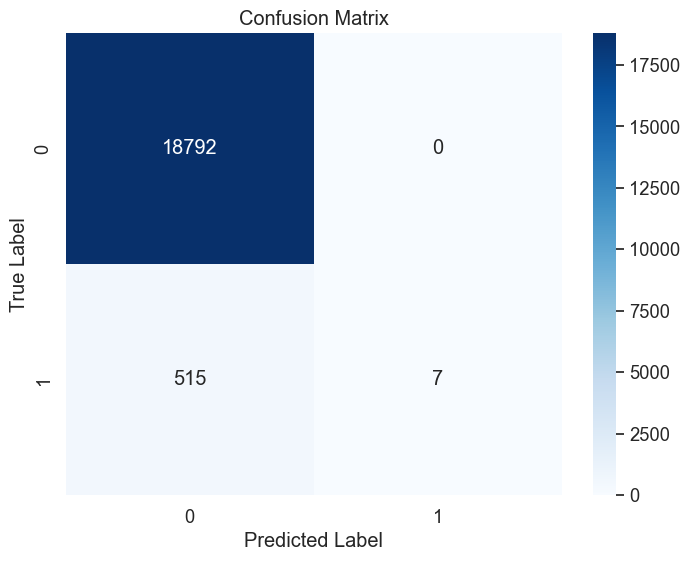

In [85]:
# Define the parameter grid to search
param_grid = {
    'estimator__C': [0.1, 1, 10]
}


svm_rbf = BaggingClassifier(SVC(kernel='rbf', probability=True,random_state=42), max_samples=1.0 / 10, n_estimators=10,random_state=42,n_jobs = -1)

# Initialize GridSearchCV
grid_search_svm_rbf = GridSearchCV(svm_rbf, param_grid, cv=5, scoring='f1',n_jobs = -1)

# Perform the grid search
grid_search_svm_rbf.fit(X_train_selected_df.drop(columns=['avgtempC']), y_train)

# Get the best model
best_svm_rbf = grid_search_svm_rbf.best_estimator_

# Make predictions
y_pred = best_svm_rbf.predict(X_test_selected_df.drop(columns=['avgtempC']))

# Calculate probability For AUC
y_proba = best_svm_rbf.predict_proba(X_test_selected_df.drop(columns=['avgtempC']))

# Evaluate the classifier
report = classification_report(y_test, y_pred)
print('SVM - rbf')
print("Best Parameters:", grid_search_svm_rbf.best_params_)
print(report)

print('AUC:',roc_auc_score(y_test, y_proba[:, 1]))
cm = confusion_matrix(y_test, y_pred, labels=best_svm_rbf.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=best_svm_rbf.classes_, yticklabels=best_svm_rbf.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### SVME - Poly

SVM - poly
Best Parameters: {'estimator__C': 0.1}
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18792
           1       0.00      0.00      0.00       522

    accuracy                           0.97     19314
   macro avg       0.49      0.50      0.49     19314
weighted avg       0.95      0.97      0.96     19314

AUC: 0.703734235567756


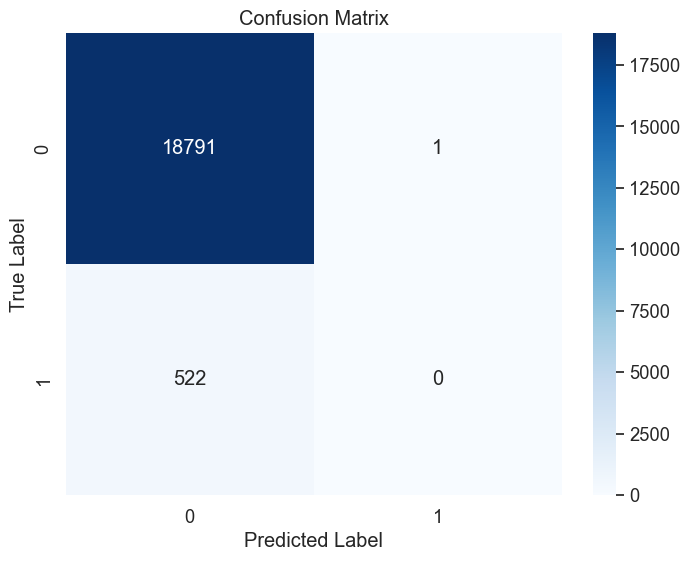

In [87]:
# Define the parameter grid to search
param_grid = {
    'estimator__C': [0.1, 1, 10]
}

svm_poly = BaggingClassifier(SVC(kernel='poly', probability=True,random_state=42), max_samples=1.0 / 10, n_estimators=10,random_state=42,n_jobs = -1)

# Initialize GridSearchCV
grid_search_svm_poly = GridSearchCV(svm_poly, param_grid, cv=5, scoring='f1',n_jobs = -1)

# Perform the grid search
grid_search_svm_poly.fit(X_train_selected_df.drop(columns=['avgtempC']), y_train)

# Get the best model
best_svm_poly = grid_search_svm_poly.best_estimator_

# Make predictions
y_pred = best_svm_poly.predict(X_test_selected_df.drop(columns=['avgtempC']))

# Calculate probability For AUC
y_proba = best_svm_poly.predict_proba(X_test_selected_df.drop(columns=['avgtempC']))

# Evaluate the classifier
report = classification_report(y_test, y_pred)
print('SVM - poly')
print("Best Parameters:", grid_search_svm_poly.best_params_)
print(report)
print('AUC:',roc_auc_score(y_test, y_proba[:, 1]))
cm = confusion_matrix(y_test, y_pred, labels=best_svm_poly.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale for better readability
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=best_svm_poly.classes_, yticklabels=best_svm_poly.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### RBFNN

In [43]:
class RadialBasisFunctionNeuralNetwork:
    def __init__(self, num_of_rbf_units=10):
        self.num_of_rbf_units = num_of_rbf_units

    def _rbf_unit(self, rbf_center, point_in_dataset):
        return np.exp(-self.beta * distance.cdist([point_in_dataset], [rbf_center], 'euclidean')**2).flatten()[0]

    def _construct_interpolation_matrix(self, input_dataset):
        interpolation_matrix = np.zeros((len(input_dataset), self.num_of_rbf_units))
        for idx, point_in_dataset in enumerate(input_dataset):
            for center_idx, rbf_center in enumerate(self.rbf_centers):
                interpolation_matrix[idx, center_idx] = self._rbf_unit(rbf_center, point_in_dataset)
        return interpolation_matrix

    def train_model(self, input_dataset, target_dataset):
        self.kmeans_clustering = KMeans(n_clusters=self.num_of_rbf_units, random_state=42).fit(input_dataset)
        self.rbf_centers = self.kmeans_clustering.cluster_centers_
        self.beta = 1.0 / (2.0 * (self.kmeans_clustering.inertia_ / input_dataset.shape[0]))
        interpolation_matrix = self._construct_interpolation_matrix(input_dataset)
        self.model_weights = np.linalg.pinv(interpolation_matrix.T.dot(interpolation_matrix)).dot(interpolation_matrix.T).dot(target_dataset)

    def predict(self, input_dataset):
        interpolation_matrix = self._construct_interpolation_matrix(input_dataset)
        predicted_values = interpolation_matrix.dot(self.model_weights)
        return predicted_values
    
def grid_search_cv(df_train, y_train, num_of_rbf_units_list, n_splits=5):
    kf = KFold(n_splits=n_splits)
    best_f1_score = 0
    best_num_of_rbf_units = None

    for num_of_rbf_units in num_of_rbf_units_list:
        f1_scores = []
        for train_index, val_index in kf.split(df_train):
            X_train_fold, X_val_fold = df_train.iloc[train_index], df_train.iloc[val_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
            
            rbf_neural_network = RadialBasisFunctionNeuralNetwork(num_of_rbf_units=num_of_rbf_units)
            rbf_neural_network.train_model(X_train_fold.values, y_train_fold.values)
            
            predictions = rbf_neural_network.predict(X_val_fold.values)
            binary_predictions = np.where(predictions > 0.5, 1, 0)
            f1 = f1_score(y_val_fold, binary_predictions)
            f1_scores.append(f1)

        avg_f1_score = np.mean(f1_scores)
        if avg_f1_score > best_f1_score:
            best_f1_score = avg_f1_score
            best_num_of_rbf_units = num_of_rbf_units

    return best_num_of_rbf_units

Best number of RBF units: 5000
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18792
           1       0.88      0.07      0.13       522

    accuracy                           0.97     19314
   macro avg       0.93      0.53      0.56     19314
weighted avg       0.97      0.97      0.96     19314

[[18787     5]
 [  486    36]]
AUC: 0.7307580445090354


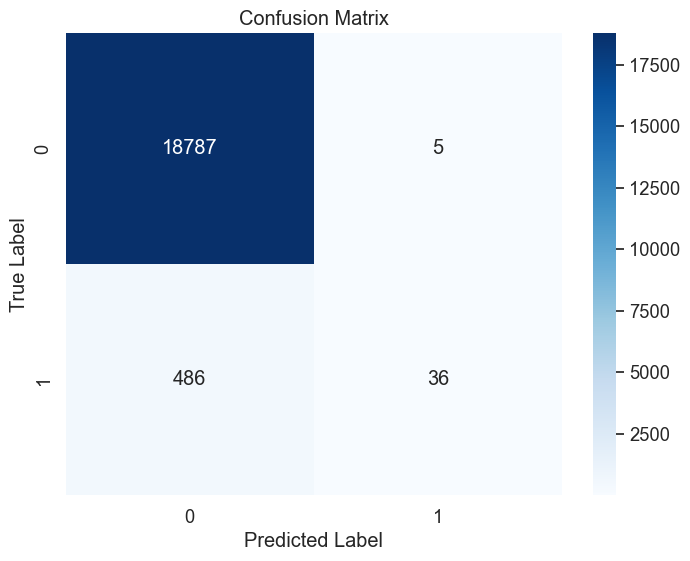

In [47]:
# Define the list of candidate values for the number of RBF units
num_of_rbf_units_list = [50, 100, 200, 500]
# Perform grid search cross-validation to find the best number of RBF units
#best_num_of_rbf_units = grid_search_cv(X_train_selected_df.drop(columns=['avgtempC']), y_train, num_of_rbf_units_list)
print("Best number of RBF units:", 5000)
# Initialize and train the RBF neural network with the best number of RBF units
rbf_neural_network = RadialBasisFunctionNeuralNetwork(num_of_rbf_units=5000)
rbf_neural_network.train_model(X_train_selected_df.drop(columns=['avgtempC']).values, y_train.values)
# Predict the target values
predictions = rbf_neural_network.predict(X_test_selected_df.drop(columns=['avgtempC']).values)
# Converting continuous output to binary labels
binary_predictions = np.where(predictions > 0.5, 1, 0)
# Print classification report
print(classification_report(y_test, binary_predictions))
# Compute confusion matrix
cm = confusion_matrix(y_test, binary_predictions, labels=[0, 1])
print(cm)
print('AUC:',roc_auc_score(y_test,predictions))
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale for better readability
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### With Temperature

#### Dummy

Dummy
Best Parameters: {'strategy': 'uniform'}
              precision    recall  f1-score   support

           0       0.97      0.50      0.66     18792
           1       0.03      0.51      0.05       522

    accuracy                           0.50     19314
   macro avg       0.50      0.51      0.36     19314
weighted avg       0.95      0.50      0.65     19314

AUC: 0.5


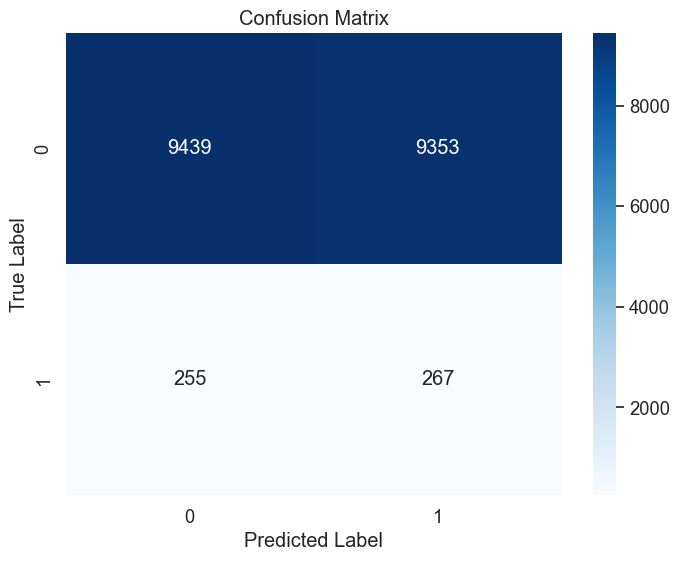

In [48]:
# Define the parameter grid to search
param_grid = {
    'strategy': ['stratified', 'most_frequent', 'uniform', 'constant','prior']
}

dc = DummyClassifier(random_state=42)

# Initialize GridSearchCV
grid_search_dc = GridSearchCV(dc, param_grid, cv=5, scoring='f1')

# Perform the grid search
grid_search_dc.fit(X_train_selected_df, y_train)

# Get the best model
best_dummy_clf = grid_search_dc.best_estimator_

# Make predictions
y_pred = best_dummy_clf.predict(X_test_selected_df)

# Calculate probability For AUC
y_proba = best_dummy_clf.predict_proba(X_test_selected_df)

# Evaluate the classifier
report = classification_report(y_test, y_pred)
print('Dummy')
print("Best Parameters:", grid_search_dc.best_params_)
print(report)
print('AUC:',roc_auc_score(y_test, y_proba[:, 1]))
cm = confusion_matrix(y_test, y_pred, labels=best_dummy_clf.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2) 
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=best_dummy_clf.classes_, yticklabels=best_dummy_clf.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### RF

RF
Best Parameters: {'max_depth': None, 'max_features': None, 'min_samples_split': 2, 'n_estimators': 500}
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     18792
           1       0.68      0.19      0.30       522

    accuracy                           0.98     19314
   macro avg       0.83      0.59      0.64     19314
weighted avg       0.97      0.98      0.97     19314

AUC: 0.7822509762041073


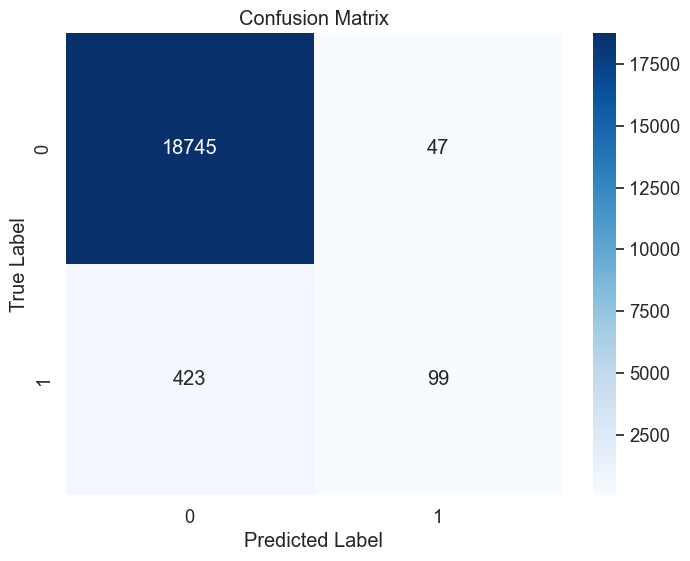

In [49]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2', 0.5, None]
}

rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(rf, param_grid, cv=5, scoring='f1', n_jobs = -1)

# Perform the grid search
grid_search_rf.fit(X_train_selected_df, y_train)

# Get the best model
best_rf = grid_search_rf.best_estimator_

# Make predictions
y_pred = best_rf.predict(X_test_selected_df)

# Calculate probability For AUC
y_proba = best_rf.predict_proba(X_test_selected_df)

# Evaluate the classifier
report = classification_report(y_test, y_pred)
print('RF')
print("Best Parameters:", grid_search_rf.best_params_)
print(report)
print('AUC:',roc_auc_score(y_test, y_proba[:, 1]))
cm = confusion_matrix(y_test, y_pred, labels=best_rf.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2) 
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=best_rf.classes_, yticklabels=best_rf.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### SVME - Linear

SVM - Linear
Best Parameters: {'estimator__C': 0.1}
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18792
           1       0.00      0.00      0.00       522

    accuracy                           0.97     19314
   macro avg       0.49      0.50      0.49     19314
weighted avg       0.95      0.97      0.96     19314

AUC: 0.6446970280823828


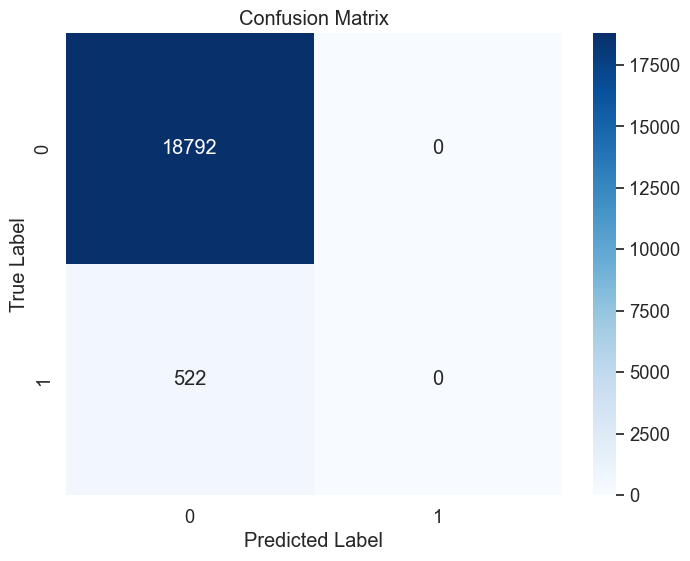

In [88]:
# Define the parameter grid to search
param_grid = {
    'estimator__C': [0.1, 1, 10]
}


svm_linear = BaggingClassifier(SVC(kernel='linear', probability=True,random_state=42), max_samples=1.0 / 10, n_estimators=10,random_state=42,n_jobs = -1)

# Initialize GridSearchCV
grid_search_svm_linear = GridSearchCV(svm_linear, param_grid, cv=5, scoring='f1',n_jobs = -1)

# Perform the grid search
grid_search_svm_linear.fit(X_train_selected_df, y_train)

# Get the best model
best_svm_linear = grid_search_svm_linear.best_estimator_

# Make predictions
y_pred = best_svm_linear.predict(X_test_selected_df)

# Calculate probability For AUC
y_proba = best_svm_linear.predict_proba(X_test_selected_df)

# Evaluate the classifier
report = classification_report(y_test, y_pred)
print('SVM - Linear')
print("Best Parameters:", grid_search_svm_linear.best_params_)
print(report)
print('AUC:',roc_auc_score(y_test, y_proba[:, 1]))
cm = confusion_matrix(y_test, y_pred, labels=best_svm_linear.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=best_svm_linear.classes_, yticklabels=best_svm_linear.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### SVME - Sigmoid

SVM - sigmoid
Best Parameters: {'estimator__C': 0.1}
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18792
           1       0.00      0.00      0.00       522

    accuracy                           0.97     19314
   macro avg       0.49      0.50      0.49     19314
weighted avg       0.95      0.97      0.96     19314

AUC: 0.6194657810693064


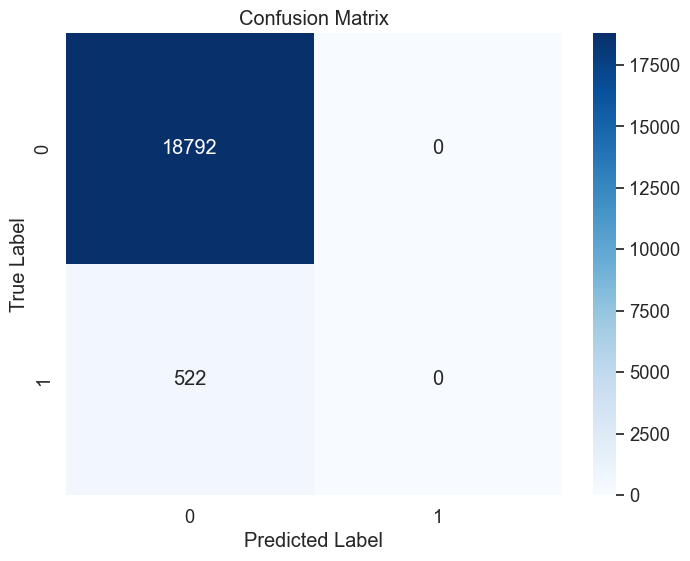

In [89]:
# Define the parameter grid to search
param_grid = {
    'estimator__C': [0.1, 1, 10]
}


svm_sigmoid = BaggingClassifier(SVC(kernel='sigmoid', probability=True,random_state=42), max_samples=1.0 / 10, n_estimators=10,random_state=42,n_jobs = -1)

# Initialize GridSearchCV
grid_search_svm_sigmoid = GridSearchCV(svm_sigmoid, param_grid, cv=5, scoring='f1',n_jobs = -1)

# Perform the grid search
grid_search_svm_sigmoid.fit(X_train_selected_df, y_train)

# Get the best model
best_svm_sigmoid = grid_search_svm_sigmoid.best_estimator_

# Make predictions
y_pred = best_svm_sigmoid.predict(X_test_selected_df)

# Calculate probability For AUC
y_proba = best_svm_sigmoid.predict_proba(X_test_selected_df)

# Evaluate the classifier
report = classification_report(y_test, y_pred)
print('SVM - sigmoid')
print("Best Parameters:", grid_search_svm_sigmoid.best_params_)
print(report)
print('AUC:',roc_auc_score(y_test, y_proba[:, 1]))
cm = confusion_matrix(y_test, y_pred, labels=best_svm_sigmoid.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=best_svm_sigmoid.classes_, yticklabels=best_svm_sigmoid.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### SVME - RBF

SVM - rbf
Best Parameters: {'estimator__C': 0.1}
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18792
           1       1.00      0.00      0.00       522

    accuracy                           0.97     19314
   macro avg       0.99      0.50      0.50     19314
weighted avg       0.97      0.97      0.96     19314

AUC: 0.7511761648798135


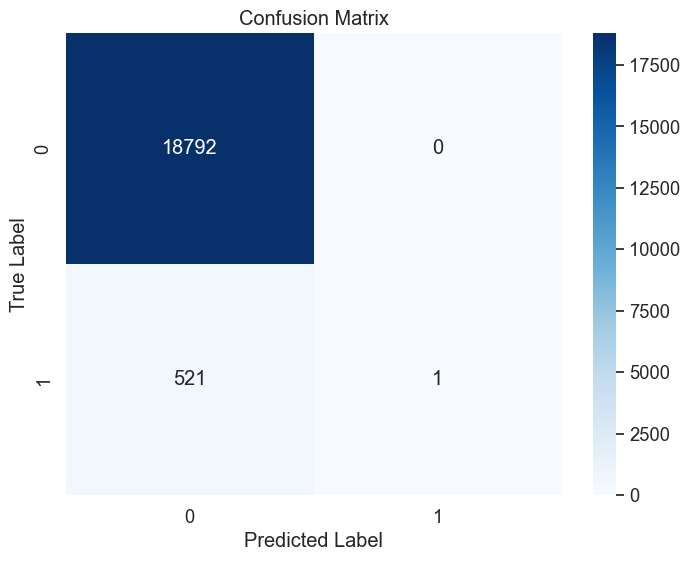

In [90]:
# Define the parameter grid to search
param_grid = {
    'estimator__C': [0.1, 1, 10]
}


svm_rbf = BaggingClassifier(SVC(kernel='rbf', probability=True,random_state=42), max_samples=1.0 / 10, n_estimators=10,random_state=42,n_jobs = -1)

# Initialize GridSearchCV
grid_search_svm_rbf = GridSearchCV(svm_rbf, param_grid, cv=5, scoring='f1',n_jobs = -1)

# Perform the grid search
grid_search_svm_rbf.fit(X_train_selected_df, y_train)

# Get the best model
best_svm_rbf = grid_search_svm_rbf.best_estimator_

# Make predictions
y_pred = best_svm_rbf.predict(X_test_selected_df)

# Calculate probability For AUC
y_proba = best_svm_rbf.predict_proba(X_test_selected_df)

# Evaluate the classifier
report = classification_report(y_test, y_pred)
print('SVM - rbf')
print("Best Parameters:", grid_search_svm_rbf.best_params_)
print(report)

print('AUC:',roc_auc_score(y_test, y_proba[:, 1]))
cm = confusion_matrix(y_test, y_pred, labels=best_svm_rbf.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=best_svm_rbf.classes_, yticklabels=best_svm_rbf.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### SVME - Poly

SVM - poly
Best Parameters: {'estimator__C': 0.1}
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18792
           1       0.00      0.00      0.00       522

    accuracy                           0.97     19314
   macro avg       0.49      0.50      0.49     19314
weighted avg       0.95      0.97      0.96     19314

AUC: 0.6924862764623081


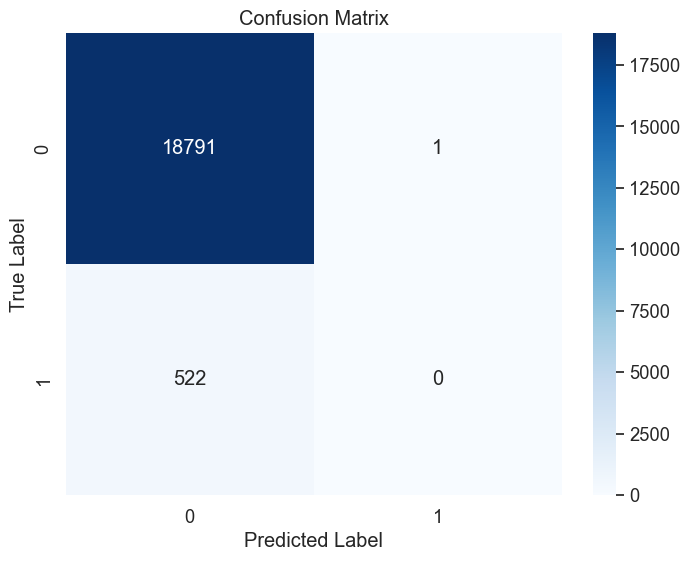

In [91]:
# Define the parameter grid to search
param_grid = {
    'estimator__C': [0.1, 1, 10]
}

svm_poly = BaggingClassifier(SVC(kernel='poly', probability=True,random_state=42), max_samples=1.0 / 10, n_estimators=10,random_state=42,n_jobs = -1)

# Initialize GridSearchCV
grid_search_svm_poly = GridSearchCV(svm_poly, param_grid, cv=5, scoring='f1',n_jobs = -1)

# Perform the grid search
grid_search_svm_poly.fit(X_train_selected_df, y_train)

# Get the best model
best_svm_poly = grid_search_svm_poly.best_estimator_

# Make predictions
y_pred = best_svm_poly.predict(X_test_selected_df)

# Calculate probability For AUC
y_proba = best_svm_poly.predict_proba(X_test_selected_df)

# Evaluate the classifier
report = classification_report(y_test, y_pred)
print('SVM - poly')
print("Best Parameters:", grid_search_svm_poly.best_params_)
print(report)
print('AUC:',roc_auc_score(y_test, y_proba[:, 1]))
cm = confusion_matrix(y_test, y_pred, labels=best_svm_poly.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=best_svm_poly.classes_, yticklabels=best_svm_poly.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### RBFNN

Best number of RBF units: 5000
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18792
           1       0.92      0.07      0.12       522

    accuracy                           0.97     19314
   macro avg       0.95      0.53      0.55     19314
weighted avg       0.97      0.97      0.96     19314

[[18789     3]
 [  488    34]]
AUC: 0.727750834299751


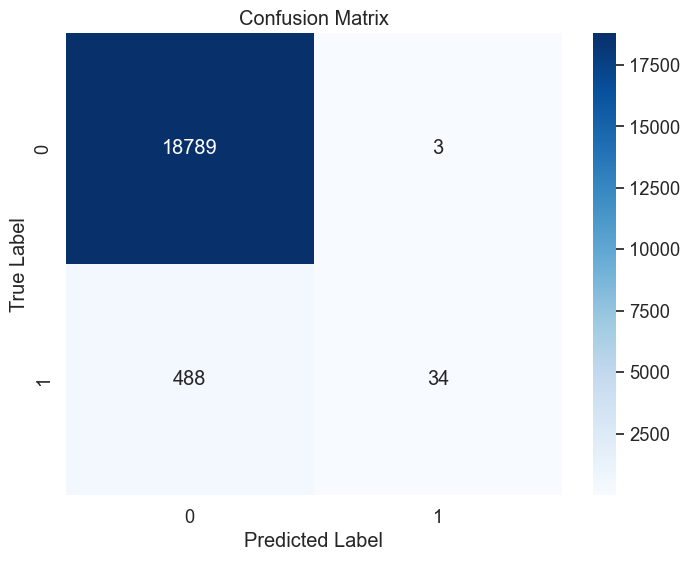

In [54]:
# Define the list of candidate values for the number of RBF units
#num_of_rbf_units_list = [50, 100, 200, 500]
# Perform grid search cross-validation to find the best number of RBF units
#best_num_of_rbf_units = grid_search_cv(X_train_selected_df, y_train, num_of_rbf_units_list)
print("Best number of RBF units:", 5000)
# Initialize and train the RBF neural network with the best number of RBF units
rbf_neural_network = RadialBasisFunctionNeuralNetwork(num_of_rbf_units=5000)
rbf_neural_network.train_model(X_train_selected_df.values, y_train.values)
# Predict the target values
predictions = rbf_neural_network.predict(X_test_selected_df.values)
# Converting continuous output to binary labels
binary_predictions = np.where(predictions > 0.5, 1, 0)
# Print classification report
print(classification_report(y_test, binary_predictions))
# Compute confusion matrix
cm = confusion_matrix(y_test, binary_predictions, labels=[0, 1])
print(cm)
print('AUC:',roc_auc_score(y_test,predictions))
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2) 
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## With SMOTE

### Without Temp

#### Dummy

Dummy
Best Parameters: {'strategy': 'uniform'}
              precision    recall  f1-score   support

           0       0.97      0.50      0.66     18792
           1       0.03      0.51      0.05       522

    accuracy                           0.50     19314
   macro avg       0.50      0.51      0.36     19314
weighted avg       0.95      0.50      0.65     19314

AUC: 0.5


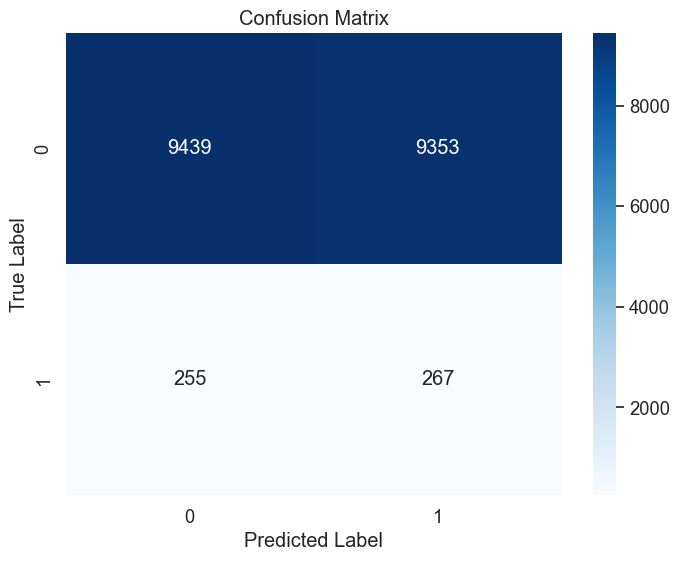

In [55]:
# Define the parameter grid to search
param_grid = {
    'strategy': ['stratified', 'most_frequent', 'uniform', 'constant','prior']
}

dc_sm = DummyClassifier(random_state=42)

# Initialize GridSearchCV
grid_search_dc_sm = GridSearchCV(dc_sm, param_grid, cv=5, scoring='f1')

# Perform the grid search
grid_search_dc_sm.fit(X_resampled.drop(columns=['avgtempC']), y_resampled)

# Get the best model
best_dummy_clf_sm = grid_search_dc_sm.best_estimator_

# Make predictions
y_pred = best_dummy_clf_sm.predict(X_test_selected_df.drop(columns=['avgtempC']))

# Calculate probability For AUC
y_proba = best_dummy_clf_sm.predict_proba(X_test_selected_df.drop(columns=['avgtempC']))

# Evaluate the classifier
report = classification_report(y_test, y_pred)
print('Dummy')
print("Best Parameters:", grid_search_dc_sm.best_params_)
print(report)
print('AUC:',roc_auc_score(y_test, y_proba[:, 1]))
cm = confusion_matrix(y_test, y_pred, labels=best_dummy_clf_sm.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2) 
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=best_dummy_clf_sm.classes_, yticklabels=best_dummy_clf_sm.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### RF

RF
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     18792
           1       0.64      0.18      0.28       522

    accuracy                           0.98     19314
   macro avg       0.81      0.59      0.63     19314
weighted avg       0.97      0.98      0.97     19314

AUC: 0.8026009478232361


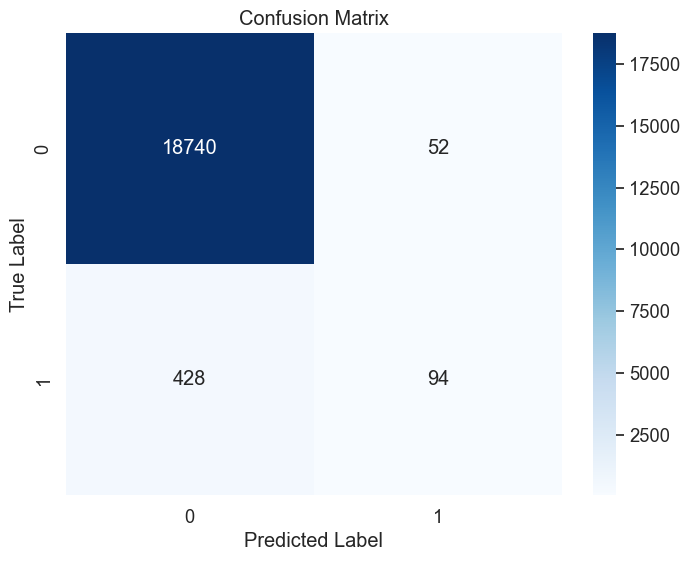

In [56]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2', 0.5, None]
}


rf_sm = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search_rf_sm = GridSearchCV(rf_sm, param_grid, cv=5, scoring='f1', n_jobs = -1)

# Perform the grid search
grid_search_rf_sm.fit(X_resampled.drop(columns=['avgtempC']), y_resampled)

# Get the best model
best_rf_sm = grid_search_rf_sm.best_estimator_

# Make predictions
y_pred = best_rf_sm.predict(X_test_selected_df.drop(columns=['avgtempC']))

# Calculate probability For AUC
y_proba = best_rf_sm.predict_proba(X_test_selected_df.drop(columns=['avgtempC']))

# Evaluate the classifier
report = classification_report(y_test, y_pred)
print('RF')
print("Best Parameters:", grid_search_rf_sm.best_params_)
print(report)
print('AUC:',roc_auc_score(y_test, y_proba[:, 1]))
cm = confusion_matrix(y_test, y_pred, labels=best_rf_sm.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2) 
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=best_rf_sm.classes_, yticklabels=best_rf_sm.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### SVME - Linear

SVM - linear
Best Parameters: {'estimator__C': 0.1}
              precision    recall  f1-score   support

           0       0.99      0.69      0.82     18792
           1       0.06      0.65      0.10       522

    accuracy                           0.69     19314
   macro avg       0.52      0.67      0.46     19314
weighted avg       0.96      0.69      0.80     19314

AUC: 0.7242353373653744


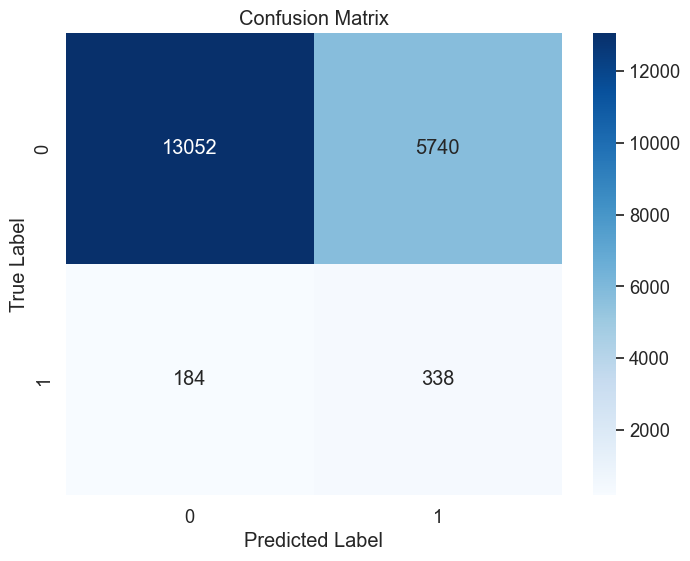

In [54]:
# Define the parameter grid to search
param_grid = {
    'estimator__C': [0.1, 1, 10]
}


svm_linear_sm = BaggingClassifier(SVC(kernel='linear', probability=True,random_state=42), max_samples=1.0 / 10, n_estimators=10,random_state=42,n_jobs = -1)

# Initialize GridSearchCV
grid_search_svm_linear_sm = GridSearchCV(svm_linear_sm, param_grid, cv=5, scoring='f1', n_jobs = -1)

# Perform the grid search
grid_search_svm_linear_sm.fit(X_resampled.drop(columns=['avgtempC']), y_resampled)

# Get the best model
best_lsvc_sm = grid_search_svm_linear_sm.best_estimator_

# Make predictions
y_pred = best_lsvc_sm.predict(X_test_selected_df.drop(columns=['avgtempC']))

# Calculate probability For AUC
y_proba = best_lsvc_sm.predict_proba(X_test_selected_df.drop(columns=['avgtempC']))

# Evaluate the classifier
report = classification_report(y_test, y_pred)
print('SVM - linear')
print("Best Parameters:", grid_search_svm_linear_sm.best_params_)
print(report)
print('AUC:',roc_auc_score(y_test, y_proba[:, 1]))
cm = confusion_matrix(y_test, y_pred, labels=grid_search_svm_linear_sm.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=grid_search_svm_linear_sm.classes_, yticklabels=grid_search_svm_linear_sm.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### SVME - Sigmoid

SVM - sigmoid
Best Parameters: {'estimator__C': 0.1}
              precision    recall  f1-score   support

           0       0.98      0.54      0.70     18792
           1       0.03      0.54      0.06       522

    accuracy                           0.54     19314
   macro avg       0.50      0.54      0.38     19314
weighted avg       0.95      0.54      0.68     19314

AUC: 0.5584812625083797


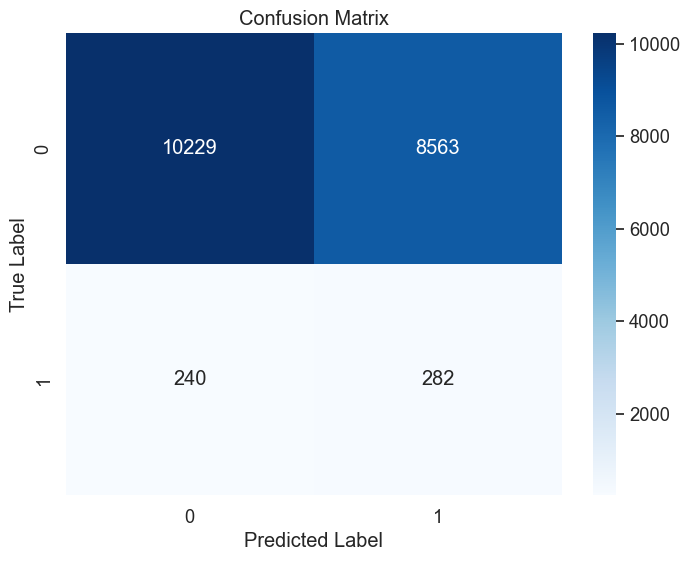

In [40]:
# Define the parameter grid to search
param_grid = {
    'estimator__C': [0.1, 1, 10]
}

svm_sigmoid_sm = BaggingClassifier(SVC(kernel='sigmoid', probability=True,random_state=42), max_samples=1.0 / 10, n_estimators=10,random_state=42,n_jobs = -1)

# Initialize GridSearchCV
grid_search_svm_sigmoid_sm = GridSearchCV(svm_sigmoid_sm, param_grid, cv=5, scoring='f1',n_jobs = -1)

# Perform the grid search
grid_search_svm_sigmoid_sm.fit(X_resampled.drop(columns=['avgtempC']), y_resampled)

# Get the best model
best_svm_sigmoid_sm = grid_search_svm_sigmoid_sm.best_estimator_

# Make predictions
y_pred = best_svm_sigmoid_sm.predict(X_test_selected_df.drop(columns=['avgtempC']))

# Calculate probability For AUC
y_proba = best_svm_sigmoid_sm.predict_proba(X_test_selected_df.drop(columns=['avgtempC']))

# Evaluate the classifier
report = classification_report(y_test, y_pred)
print('SVM - sigmoid')
print("Best Parameters:", grid_search_svm_sigmoid_sm.best_params_)
print(report)
print('AUC:',roc_auc_score(y_test, y_proba[:, 1]))
cm = confusion_matrix(y_test, y_pred, labels=best_svm_sigmoid_sm.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2) 
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=best_svm_sigmoid_sm.classes_, yticklabels=best_svm_sigmoid_sm.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### SVME - RBF

SVM - rbf
Best Parameters: {'estimator__C': 10}
              precision    recall  f1-score   support

           0       0.98      0.95      0.97     18792
           1       0.16      0.31      0.21       522

    accuracy                           0.94     19314
   macro avg       0.57      0.63      0.59     19314
weighted avg       0.96      0.94      0.95     19314

AUC: 0.7634938096263348


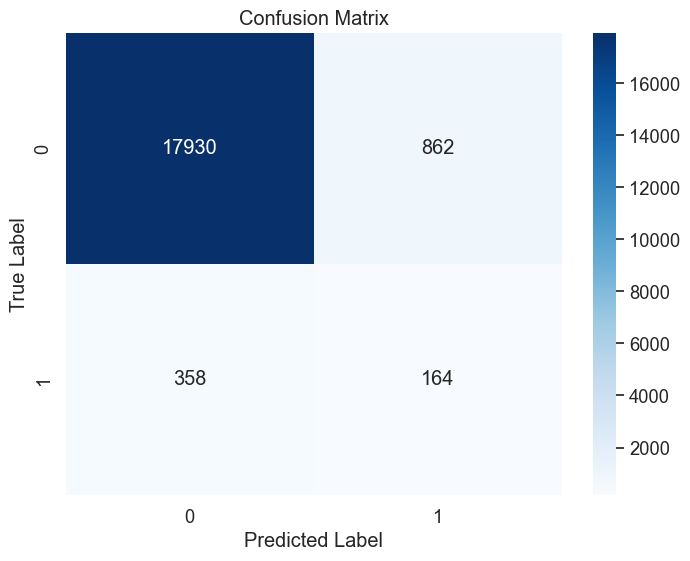

In [45]:
# Define the parameter grid to search
param_grid = {
    'estimator__C': [0.1, 1, 10]
}

svm_rbf_sm = BaggingClassifier(SVC(kernel='rbf', probability=True,random_state=42), max_samples=1.0 / 10, n_estimators=10,random_state=42,n_jobs = -1)

# Initialize GridSearchCV
grid_search_svm_rbf_sm = GridSearchCV(svm_rbf_sm, param_grid, cv=5, scoring='f1',n_jobs = -1)

# Perform the gridsearch
grid_search_svm_rbf_sm.fit(X_resampled.drop(columns=['avgtempC']), y_resampled)

# Get the best model
best_svm_rbf_sm = grid_search_svm_rbf_sm.best_estimator_

# Make predictions
y_pred = best_svm_rbf_sm.predict(X_test_selected_df.drop(columns=['avgtempC']))

# Calculate probability For AUC
y_proba = best_svm_rbf_sm.predict_proba(X_test_selected_df.drop(columns=['avgtempC']))

# Evaluate the classifier
report = classification_report(y_test, y_pred)
print('SVM - rbf')
print("Best Parameters:", grid_search_svm_rbf_sm.best_params_)
print(report)

print('AUC:',roc_auc_score(y_test, y_proba[:, 1]))
cm = confusion_matrix(y_test, y_pred, labels=best_svm_rbf_sm.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2) 
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=best_svm_rbf_sm.classes_, yticklabels=best_svm_rbf_sm.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### SVME - Poly

SVM - poly
Best Parameters: {'estimator__C': 10}
              precision    recall  f1-score   support

           0       0.98      0.93      0.95     18792
           1       0.12      0.38      0.19       522

    accuracy                           0.91     19314
   macro avg       0.55      0.65      0.57     19314
weighted avg       0.96      0.91      0.93     19314

AUC: 0.765429703109989


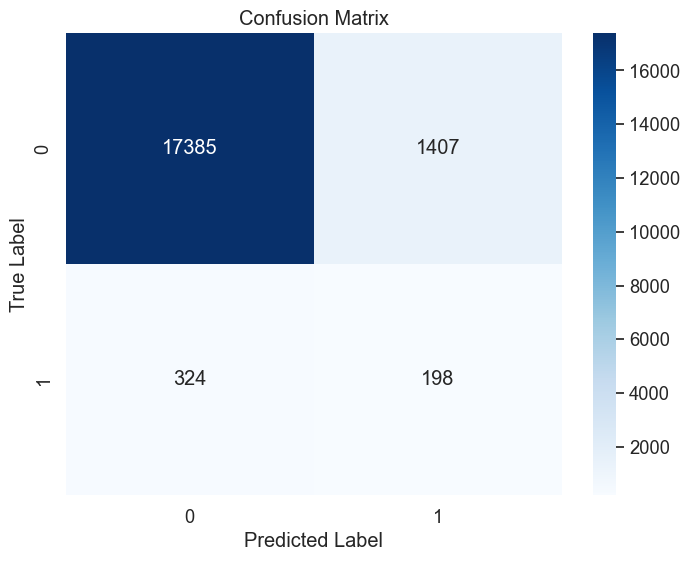

In [46]:
# Define the parameter grid to search
param_grid = {
    'estimator__C': [0.1, 1, 10]
}

svm_poly_sm = BaggingClassifier(SVC(kernel='poly', probability=True,random_state=42), max_samples=1.0 / 10, n_estimators=10,random_state=42,n_jobs = -1)

# Initialize GridSearchCV
grid_search_svm_poly_sm = GridSearchCV(svm_poly_sm, param_grid, cv=5, scoring='f1',n_jobs = -1)

# Perform the grid search
grid_search_svm_poly_sm.fit(X_resampled.drop(columns=['avgtempC']), y_resampled)

# Get the best model
best_svm_poly_sm = grid_search_svm_poly_sm.best_estimator_

# Make predictions
y_pred = best_svm_poly_sm.predict(X_test_selected_df.drop(columns=['avgtempC']))

# Calculate probability For AUC
y_proba = best_svm_poly_sm.predict_proba(X_test_selected_df.drop(columns=['avgtempC']))

# Evaluate the classifier
report = classification_report(y_test, y_pred)
print('SVM - poly')
print("Best Parameters:", grid_search_svm_poly_sm.best_params_)
print(report)
print('AUC:',roc_auc_score(y_test, y_proba[:, 1]))
cm = confusion_matrix(y_test, y_pred, labels=best_svm_poly_sm.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2) 
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=best_svm_poly_sm.classes_, yticklabels=best_svm_poly_sm.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### RBFNN

Best number of RBF units: 5000
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     18792
           1       0.18      0.28      0.22       522

    accuracy                           0.94     19314
   macro avg       0.58      0.62      0.59     19314
weighted avg       0.96      0.94      0.95     19314

[[18099   693]
 [  374   148]]
AUC: 0.7289505989342494


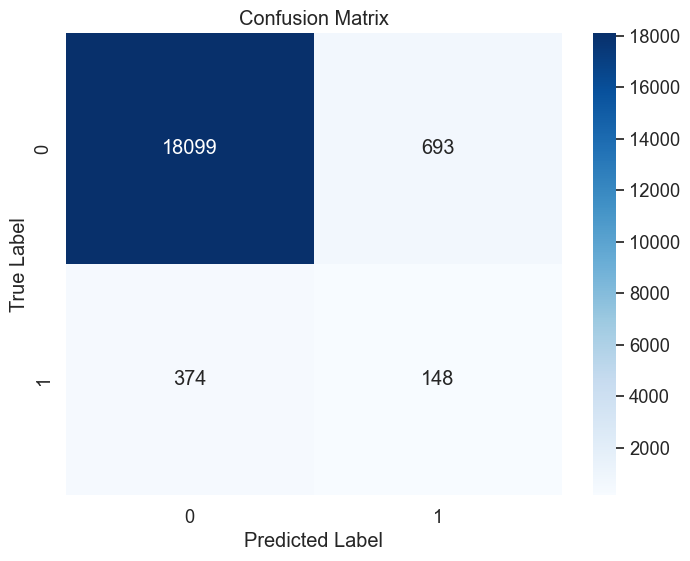

In [47]:
print("Best number of RBF units:", 5000)
rbf_neural_network_sm = RadialBasisFunctionNeuralNetwork(num_of_rbf_units=5000)
rbf_neural_network_sm.train_model(X_resampled.drop(columns=['avgtempC']).values, y_resampled.values)
# Predict the target values
predictions = rbf_neural_network_sm.predict(X_test_selected_df.drop(columns=['avgtempC']).values)
# Converting continuous output to binary labels
binary_predictions = np.where(predictions > 0.5, 1, 0)
# Print classification report
print(classification_report(y_test, binary_predictions))
# Compute confusion matrix
cm = confusion_matrix(y_test, binary_predictions, labels=[0, 1])
print(cm)
print('AUC:',roc_auc_score(y_test,predictions))
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### With Temp

#### Dummy

Dummy
Best Parameters: {'strategy': 'uniform'}
              precision    recall  f1-score   support

           0       0.97      0.50      0.66     18792
           1       0.03      0.51      0.05       522

    accuracy                           0.50     19314
   macro avg       0.50      0.51      0.36     19314
weighted avg       0.95      0.50      0.65     19314

AUC: 0.5


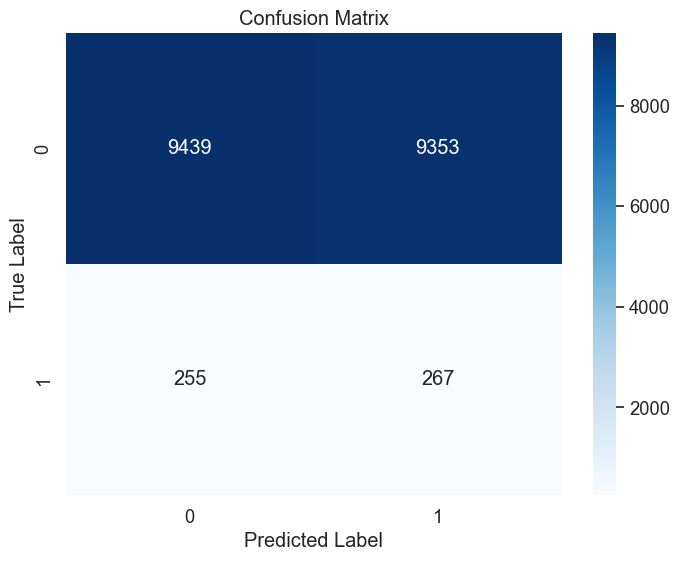

In [48]:
# Define the parameter grid to search
param_grid = {
    'strategy': ['stratified', 'most_frequent', 'uniform', 'constant','prior']
}

dc_sm = DummyClassifier(random_state=42)

# Initialize GridSearchCV
grid_search_dc_sm = GridSearchCV(dc_sm, param_grid, cv=5, scoring='f1')

# Perform the grid search
grid_search_dc_sm.fit(X_resampled, y_resampled)

# Get the best model
best_dummy_clf_sm = grid_search_dc_sm.best_estimator_

# Make predictions
y_pred = best_dummy_clf_sm.predict(X_test_selected_df)

# Calculate probability For AUC
y_proba = best_dummy_clf_sm.predict_proba(X_test_selected_df)

# Evaluate the classifier
report = classification_report(y_test, y_pred)
print('Dummy')
print("Best Parameters:", grid_search_dc_sm.best_params_)
print(report)
print('AUC:',roc_auc_score(y_test, y_proba[:, 1]))
cm = confusion_matrix(y_test, y_pred, labels=best_dummy_clf_sm.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2) 
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=best_dummy_clf_sm.classes_, yticklabels=best_dummy_clf_sm.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### RF

RF
Best Parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     18792
           1       0.66      0.18      0.28       522

    accuracy                           0.98     19314
   macro avg       0.82      0.59      0.63     19314
weighted avg       0.97      0.98      0.97     19314

AUC: 0.7985489769837658


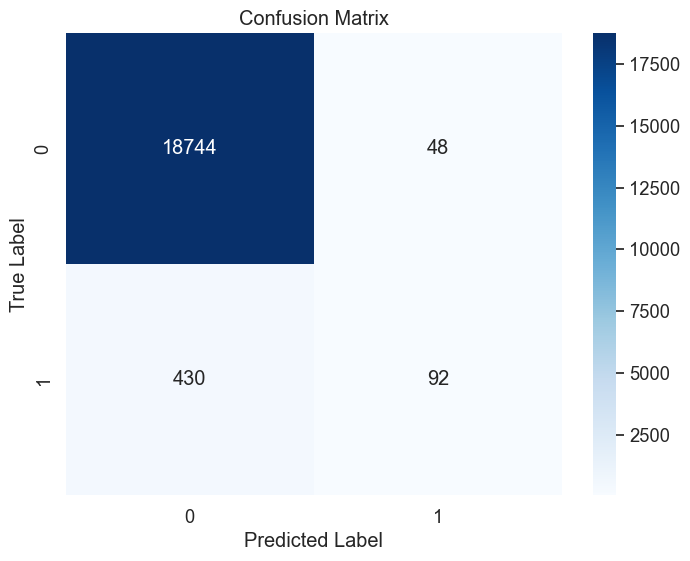

In [49]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2', 0.5, None]
}


rf_sm = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search_rf_sm = GridSearchCV(rf_sm, param_grid, cv=5, scoring='f1', n_jobs = -1)

# Perform the grid search
grid_search_rf_sm.fit(X_resampled, y_resampled)

# Get the best model
best_rf_sm = grid_search_rf_sm.best_estimator_

# Make predictions
y_pred = best_rf_sm.predict(X_test_selected_df)

# Calculate probability For AUC
y_proba = best_rf_sm.predict_proba(X_test_selected_df)

# Evaluate the classifier
report = classification_report(y_test, y_pred)
print('RF')
print("Best Parameters:", grid_search_rf_sm.best_params_)
print(report)
print('AUC:',roc_auc_score(y_test, y_proba[:, 1]))
cm = confusion_matrix(y_test, y_pred, labels=best_rf_sm.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=best_rf_sm.classes_, yticklabels=best_rf_sm.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### SVME - Linear

SVM - linear
Best Parameters: {'estimator__C': 0.1}
              precision    recall  f1-score   support

           0       0.99      0.69      0.81     18792
           1       0.06      0.65      0.10       522

    accuracy                           0.69     19314
   macro avg       0.52      0.67      0.46     19314
weighted avg       0.96      0.69      0.80     19314

AUC: 0.7241668318139781


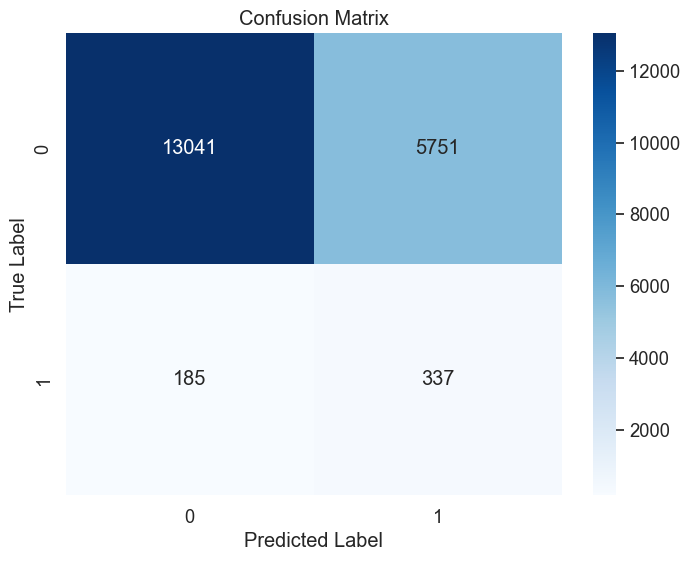

In [56]:
# Define the parameter grid to search
param_grid = {
    'estimator__C': [0.1, 1, 10]
}

svm_linear_sm = BaggingClassifier(SVC(kernel='linear', probability=True, random_state=42), max_samples=1.0 / 10, n_estimators=10,random_state=42,n_jobs = -1)

# Initialize GridSearchCV
grid_search_svm_linear_sm = GridSearchCV(svm_linear_sm, param_grid, cv=5, scoring='f1', n_jobs = -1)

# Perform the grid search
grid_search_svm_linear_sm.fit(X_resampled, y_resampled)

# Get the best model
best_svm_linear_sm = grid_search_svm_linear_sm.best_estimator_

# Make predictions
y_pred = best_svm_linear_sm.predict(X_test_selected_df)

# Calculate probability For AUC
y_proba = best_svm_linear_sm.predict_proba(X_test_selected_df)

# Evaluate the classifier
report = classification_report(y_test, y_pred)
print('SVM - linear')
print("Best Parameters:", grid_search_svm_linear_sm.best_params_)
print(report)
print('AUC:',roc_auc_score(y_test, y_proba[:, 1]))
cm = confusion_matrix(y_test, y_pred, labels=grid_search_svm_linear_sm.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2) 
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=grid_search_svm_linear_sm.classes_, yticklabels=grid_search_svm_linear_sm.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### SVME - Sigmoid

SVM - sigmoid
Best Parameters: {'estimator__C': 0.1}
              precision    recall  f1-score   support

           0       0.98      0.54      0.70     18792
           1       0.03      0.55      0.06       522

    accuracy                           0.54     19314
   macro avg       0.50      0.54      0.38     19314
weighted avg       0.95      0.54      0.68     19314

AUC: 0.561488574660449


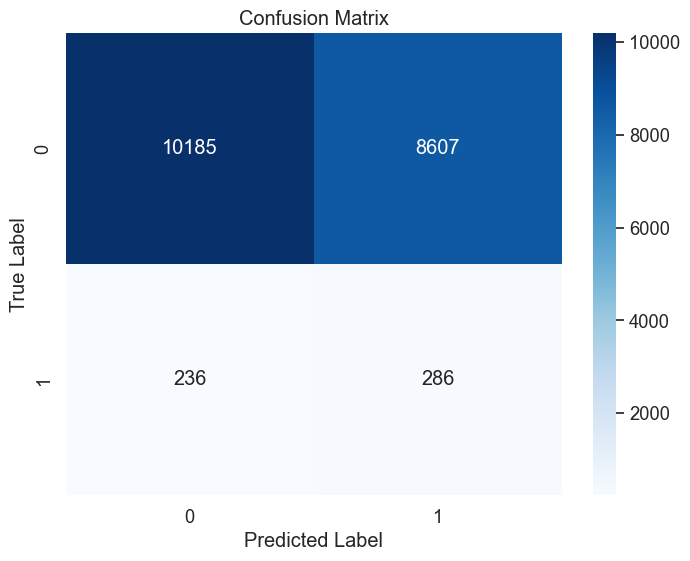

In [50]:
# Define the parameter grid to search
param_grid = {
    'estimator__C': [0.1, 1, 10]
}

svm_sigmoid_sm = BaggingClassifier(SVC(kernel='sigmoid', probability=True,random_state=42), max_samples=1.0 / 10, n_estimators=10,random_state=42,n_jobs = -1)

# Initialize GridSearchCV
grid_search_svm_sigmoid_sm = GridSearchCV(svm_sigmoid_sm, param_grid, cv=5, scoring='f1',n_jobs = -1)

# Perform the grid search
grid_search_svm_sigmoid_sm.fit(X_resampled, y_resampled)

# Get the best model
best_svm_sigmoid_sm = grid_search_svm_sigmoid_sm.best_estimator_

# Make predictions
y_pred = best_svm_sigmoid_sm.predict(X_test_selected_df)

# Calculate probability For AUC
y_proba = best_svm_sigmoid_sm.predict_proba(X_test_selected_df)

# Evaluate the classifier
report = classification_report(y_test, y_pred)
print('SVM - sigmoid')
print("Best Parameters:", grid_search_svm_sigmoid_sm.best_params_)
print(report)
print('AUC:',roc_auc_score(y_test, y_proba[:, 1]))
cm = confusion_matrix(y_test, y_pred, labels=best_svm_sigmoid_sm.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=best_svm_sigmoid_sm.classes_, yticklabels=best_svm_sigmoid_sm.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### SVME - RBF

SVM - rbf
Best Parameters: {'estimator__C': 10}
              precision    recall  f1-score   support

           0       0.98      0.95      0.97     18792
           1       0.15      0.31      0.21       522

    accuracy                           0.93     19314
   macro avg       0.57      0.63      0.59     19314
weighted avg       0.96      0.93      0.95     19314

AUC: 0.7590323855916514


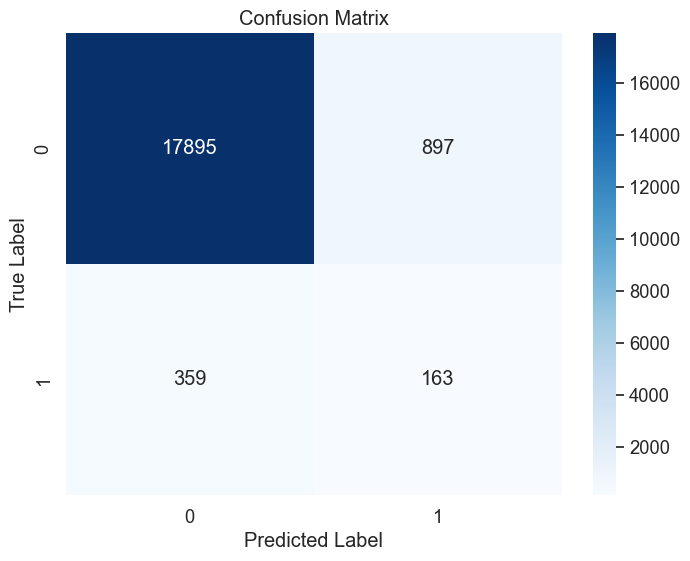

In [51]:
# Define the parameter grid to search
param_grid = {
    'estimator__C': [0.1, 1, 10]
}

svm_rbf_sm = BaggingClassifier(SVC(kernel='rbf', probability=True,random_state=42), max_samples=1.0 / 10, n_estimators=10,random_state=42,n_jobs = -1)

# Initialize GridSearchCV
grid_search_svm_rbf_sm = GridSearchCV(svm_rbf_sm, param_grid, cv=5, scoring='f1',n_jobs = -1)

# Perform the grid search
grid_search_svm_rbf_sm.fit(X_resampled, y_resampled)

# Get the best model
best_svm_rbf_sm = grid_search_svm_rbf_sm.best_estimator_

# Make predictions
y_pred = best_svm_rbf_sm.predict(X_test_selected_df)

# Calculate probability For AUC
y_proba = best_svm_rbf_sm.predict_proba(X_test_selected_df)

# Evaluate the classifier
report = classification_report(y_test, y_pred)
print('SVM - rbf')
print("Best Parameters:", grid_search_svm_rbf_sm.best_params_)
print(report)

print('AUC:',roc_auc_score(y_test, y_proba[:, 1]))
cm = confusion_matrix(y_test, y_pred, labels=best_svm_rbf_sm.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=best_svm_rbf_sm.classes_, yticklabels=best_svm_rbf_sm.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### SVME - Poly

SVM - poly
Best Parameters: {'estimator__C': 10}
              precision    recall  f1-score   support

           0       0.98      0.92      0.95     18792
           1       0.12      0.38      0.18       522

    accuracy                           0.91     19314
   macro avg       0.55      0.65      0.57     19314
weighted avg       0.96      0.91      0.93     19314

AUC: 0.7594258847410409


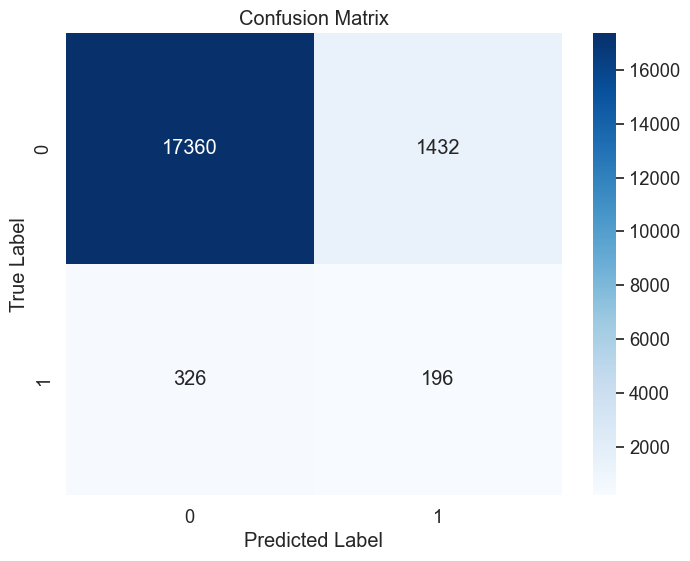

In [52]:
# Define the parameter grid to search
param_grid = {
    'estimator__C': [0.1, 1, 10]
}

svm_poly_sm = BaggingClassifier(SVC(kernel='poly', probability=True,random_state=42), max_samples=1.0 / 10, n_estimators=10,random_state=42,n_jobs = -1)

# Initialize GridSearchCV
grid_search_svm_poly_sm = GridSearchCV(svm_poly_sm, param_grid, cv=5, scoring='f1',n_jobs = -1)

# Perform the grid search
grid_search_svm_poly_sm.fit(X_resampled, y_resampled)

# Get the best model
best_svm_poly_sm = grid_search_svm_poly_sm.best_estimator_

# Make predictions
y_pred = best_svm_poly_sm.predict(X_test_selected_df)

# Calculate probability For AUC
y_proba = best_svm_poly_sm.predict_proba(X_test_selected_df)

# Evaluate the classifier
report = classification_report(y_test, y_pred)
print('SVM - poly')
print("Best Parameters:", grid_search_svm_poly_sm.best_params_)
print(report)
print('AUC:',roc_auc_score(y_test, y_proba[:, 1]))
cm = confusion_matrix(y_test, y_pred, labels=best_svm_poly_sm.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2) 
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=best_svm_poly_sm.classes_, yticklabels=best_svm_poly_sm.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### RBFNN

Best number of RBF units: 5000
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     18792
           1       0.17      0.27      0.21       522

    accuracy                           0.94     19314
   macro avg       0.57      0.62      0.59     19314
weighted avg       0.96      0.94      0.95     19314

AUC: 0.7318151911875763


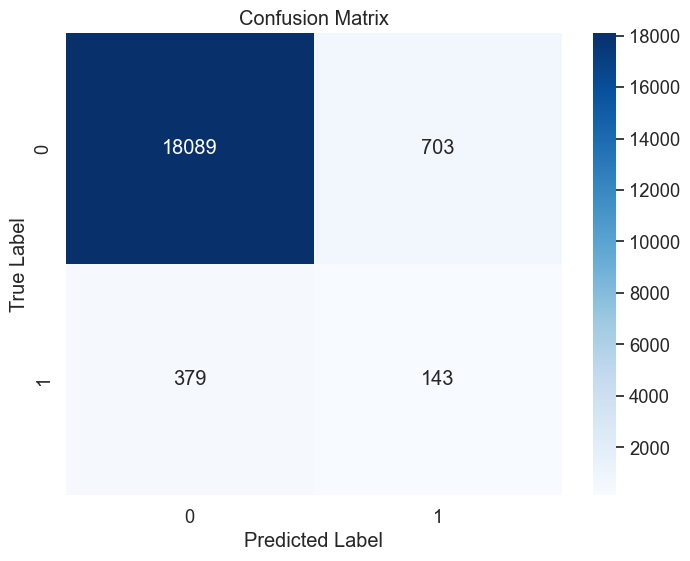

In [53]:
print("Best number of RBF units:", 5000)
rbf_neural_network_sm = RadialBasisFunctionNeuralNetwork(num_of_rbf_units=5000)
rbf_neural_network_sm.train_model(X_resampled.values, y_resampled.values)
# Predict the target values
predictions = rbf_neural_network_sm.predict(X_test_selected_df.values)
# Converting continuous output to binary labels
binary_predictions = np.where(predictions > 0.5, 1, 0)
# Print classification report
print(classification_report(y_test, binary_predictions))
# Compute confusion matrix
cm = confusion_matrix(y_test, binary_predictions, labels=[0, 1])
print('AUC:',roc_auc_score(y_test,predictions))
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()